# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

## Izhikevich Spiking network model in NEST

For every neuron $i$ in region node $n$ modelled in ANNarchy as a spiking network:

Membrane potential:

$ \dot{V}_m = n_2V_m^2 + n_1V_m + n_0140 - U_m/C $

$\;\;\;\;\;\;\;- g_{AMPA}(V_m-E_{AMPA}) - g_{GABA}(V_m-E_{GABA}) - g_{BASE}V_m + I_e $

where the conductances follow the equations:

$ \dot{g}_{AMPA} = - g_{AMPA} / \tau_{AMPA} + \left[\sum_k \delta(t-t_k) \right]_{Exc}$

$ \dot{g}_{GABA} = - g_{GABA} / \tau_{GABA} + \left[\sum_k \delta(t-t_k) \right]_{Inh}$

$ \dot{g}_{BASE} = - g_{BASE} / \tau_{BASE} + \left[\sum_k \delta(t-t_k) \right]_{BASE}$

and recovery variable:

$ \dot{U}_m = a(bV_m - U_m)$


When $ V_m > V_{th} $ , $ V_m $ is set to $ c $, and $ U_m $ is incremented by $ d $.

# WORKFLOW:

In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data")
outputs_path = os.path.join(work_path, "outputs/Izhikevich")
sim_mode_path = os.path.join(outputs_path, "TVBcortex_opt/stim")
config = Config(output_base=sim_mode_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

2021-03-10 14:30:11,775 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-03-10 14:30:11,775 - INFO - tvb_multiscale.tvb_nest.config - Loading a NEST instance...
2021-03-10 14:30:11,778 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-03-10 14:30:11,778 - INFO - tvb_multiscale.tvb_nest.config - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2021-03-10 14:30:11,782 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-03-10 14:30:11,782 - INFO - tvb_multiscale.tvb_nest.config - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2021-03-10 14:30:11,787 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-03-10 14:30:11,787 - INFO - tvb_multiscale.tvb_nest.config - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2021-03-10 14:30:11,792 - INFO - tvb_multiscale.tv

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

In [2]:
from tvb.simulator.models.reduced_wong_wang_exc_io import ReducedWongWangExcIO

# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the simulator by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------

from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# 0. GPe_Left, 1. GPi_Left, 2. STN_Left, 3. Striatum_Left, 4. Thal_Left
BG_opt_matrix_weights = np.zeros((5, 5))
conn_mode = "subject" # "average"
if conn_mode == "average":
    weights_maith = np.array([1.93, 3.56, 1.46, 4.51, 3.52, 2.30, 2.34, 3.78, 1.98, 
                             1.30, 1.82, 3.56, 3.02, 1.78, 1.36, 2.27, 4.13, 2.74, 3.27])*1e-3  # controls
#     weights_maith = np.array([3.27, 3.80, 2.65, 3.66, 3.06, 3.06, 3.25, 4.02, 3.32, 
#                             2.98, 3.45, 3.64, 2.50, 2.12, 2.86, 2.79, 3.96, 3.69, 3.87])*1e-3   # patients
    # probs_maith = ????
else:
    import scipy.io as sio
    conn_path = os.path.join(data_path, "basal_ganglia_conn_incl_cortex")
    weights=sio.loadmat(os.path.join(conn_path,"OutputSim_Patient01.mat")) # weights start from index 19
    weights_maith = weights["X"][0, 19:] # these are indices 19 till 37
    probs_maith = weights["X"][0, :19] # these are indices 0 till 18

wdSNGPi = BG_opt_matrix_weights[3, 1] = weights_maith[0]
wiSNGPe = BG_opt_matrix_weights[3, 0] = weights_maith[1]
wGPeSTN = BG_opt_matrix_weights[0, 2] = weights_maith[2]
wSTNGPe = BG_opt_matrix_weights[2, 0] = weights_maith[3]
wSTNGPi = BG_opt_matrix_weights[2, 1] = weights_maith[4]
wGPeGPi = BG_opt_matrix_weights[0, 1] = weights_maith[5]  
wGPiTh = BG_opt_matrix_weights[1, 4] = weights_maith[8]
wThdSN = BG_opt_matrix_weights[4, 3] = weights_maith[10] # Th -> dSN
    
sliceBGnet = slice(0,5)

wGPeGPe = weights_maith[6]   # "GPe" -> "GPe" 
wGPiGPi = weights_maith[7]   # "GPi" -> "GPi" 
wThiSN = weights_maith[9]    # "Eth" -> "IiSN" 

wdSNdSN = weights_maith[11]  # "IdSN" -> "IdSN" 
wiSNiSN = weights_maith[12]  # "IiSN" -> "IiSN" 
wCtxdSN = weights_maith[13]  # "CxE" -> "IdSN" 
wCtxiSN = weights_maith[14] # "CxE" -> "IiSN" 
wCtxSTN = weights_maith[15]  # "CxE" -> "Estn"
wCtxEtoI = weights_maith[16] # "CxE" -> "CxI"
wCtxItoE = weights_maith[17] # "CxI" -> "CxE"
wCtxItoI = weights_maith[18] # "CxI" -> "CxI"

pdSNGPi = probs_maith[0]
piSNGPe = probs_maith[1]
pGPeSTN = probs_maith[2]
pSTNGPe = probs_maith[3]
pSTNGPi = probs_maith[4]
pGPeGPi = probs_maith[5]  
pGPeGPe = probs_maith[6]  # "GPe" -> "GPe" 
pGPiGPi = probs_maith[7]  # "GPi" -> "GPi" 
pGPiTh = probs_maith[8]
pThiSN =  probs_maith[9]  # "Eth" -> "IiSN
pThdSN = probs_maith[10] # Th --> dSN
pdSNdSN = probs_maith[11] # "IdSN" -> "IdSN" 
piSNiSN = probs_maith[12] # "IiSN" -> "IiSN" 
pCtxdSN = probs_maith[13]  # "CxE" -> "IdSN" 
pCtxiSN = probs_maith[14] # "CxE" -> "IiSN" 
pCtxSTN = probs_maith[15]  # "CxE" -> "Estn"
pCtxEtoI = probs_maith[16] # "CxE" -> "CxI"
pCtxItoE = probs_maith[17] # "CxI" -> "CxE"
pCtxItoI = probs_maith[18] # "CxI" -> "CxI"
    
loadedParams ={'dSNGPi_probs': probs_maith[0],
    	'dSNGPi_weights'  : weights_maith[0],
    	'iSNGPe_probs'   : probs_maith[1],
    	'iSNGPe_weights'  : weights_maith[1],
    	'GPeSTN_probs'   : probs_maith[2],
    	'GPeSTN_weights'  : weights_maith[2],
    	'STNGPe_probs'   : probs_maith[3],
    	'STNGPe_weights'  : weights_maith[3],
    	'STNGPi_probs'   : probs_maith[4],
    	'STNGPi_weights' : weights_maith[4],
    	'GPeGPi_probs'   : probs_maith[5],
    	'GPeGPi_weights'  : weights_maith[5],
    	'GPeGPe_probs'   : probs_maith[6],
    	'GPeGPe_weights'  : weights_maith[6],
    	'GPiGPi_probs'   : probs_maith[7],
    	'GPiGPi_weights'  : weights_maith[7],
    	'GPiThal_probs'   : probs_maith[8],
    	'GPiThal_weights'  : weights_maith[8],
    	'ThaliSN_probs'   : probs_maith[9],
    	'ThaliSN_weights'  : weights_maith[9],
    	'ThaldSN_probs'   : probs_maith[10],
    	'ThaldSN_weights'  : weights_maith[10],
    	'dSNdSN_probs'   : probs_maith[11],
    	'dSNdSN_weights'  : weights_maith[11],
    	'iSNiSN_probs'   : probs_maith[12],
    	'iSNiSN_weights'  : weights_maith[12],
    	'CtxdSN_probs'   : probs_maith[13],
    	'CtxdSN_weights'  : weights_maith[13],
    	'CtxiSN_probs'   : probs_maith[14],
    	'CtxiSN_weights'  : weights_maith[14],
    	'CtxSTN_probs'   : probs_maith[15],
    	'CtxSTN_weights'  : weights_maith[15],
    	'CtxECtxI_probs'    : probs_maith[16],
    	'CtxECtxI_weights'  : weights_maith[16],
    	'CtxICtxE_probs'    : probs_maith[17],
    	'CtxICtxE_weights'  : weights_maith[17],
    	'CtxICtxI_probs'   : probs_maith[18],
    	'CtxICtxI_weights'  : weights_maith[18],
        'CtxThal_weights': 0.0,
        'CtxThal_probs': 1.0}
print(loadedParams)

assert_loadedParams = dict(zip(loadedParams.values(), loadedParams.keys()))
                            

{'dSNGPi_probs': 0.17029162198305128, 'dSNGPi_weights': 0.009132171887904406, 'iSNGPe_probs': 0.4074640914797783, 'iSNGPe_weights': 0.007663531694561243, 'GPeSTN_probs': 0.18478520214557648, 'GPeSTN_weights': 0.006760342903435231, 'STNGPe_probs': 0.4119542151689529, 'STNGPe_weights': 0.010754598900675774, 'STNGPi_probs': 0.2458414003252983, 'STNGPi_weights': 0.013566167578101158, 'GPeGPi_probs': 0.32317305132746693, 'GPeGPi_weights': 0.006238304376602173, 'GPeGPe_probs': 0.3238955348730087, 'GPeGPe_weights': 0.007731672264635564, 'GPiGPi_probs': 0.31747561842203137, 'GPiGPi_weights': 0.011985597293823957, 'GPiThal_probs': 0.25937364250421524, 'GPiThal_weights': 0.006650131419301033, 'ThaliSN_probs': 0.1753483198583126, 'ThaliSN_weights': 0.006984027139842511, 'ThaldSN_probs': 0.12791343107819556, 'ThaldSN_weights': 0.012284493483603, 'dSNdSN_probs': 0.44881010577082636, 'dSNdSN_weights': 0.008113504592329264, 'iSNiSN_probs': 0.20492168664932248, 'iSNiSN_weights': 0.013962633926421403, 

Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:
 [[   0.    0. 2642.    0.  781.    0.  200.    0.]
 [   0.    0.    0. 1034.    0.   45.    0. 1025.]
 [2642.    0.    0.    0. 6058.    0. 1337.    0.]
 [   0. 1034.    0.    0.    0.  162.    0.  381.]
 [ 781.    0. 6058.    0.    0.    0. 1026.    0.]
 [   0.   45.    0.  162.    0.    0.    0.  989.]
 [ 200.    0. 1337.    0. 1026.    0.    0.    0.]
 [   0. 1025.    0.  381.    0.  989.    0.    0.]]
Removing BG -> Cortex connections with max:
1931.34115274226
Removing Cortex -> Thalamus connections with summed weight:
7385.840310132234
Removing BG <- Cortex connections with max:
1682.84151027352

Left cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:


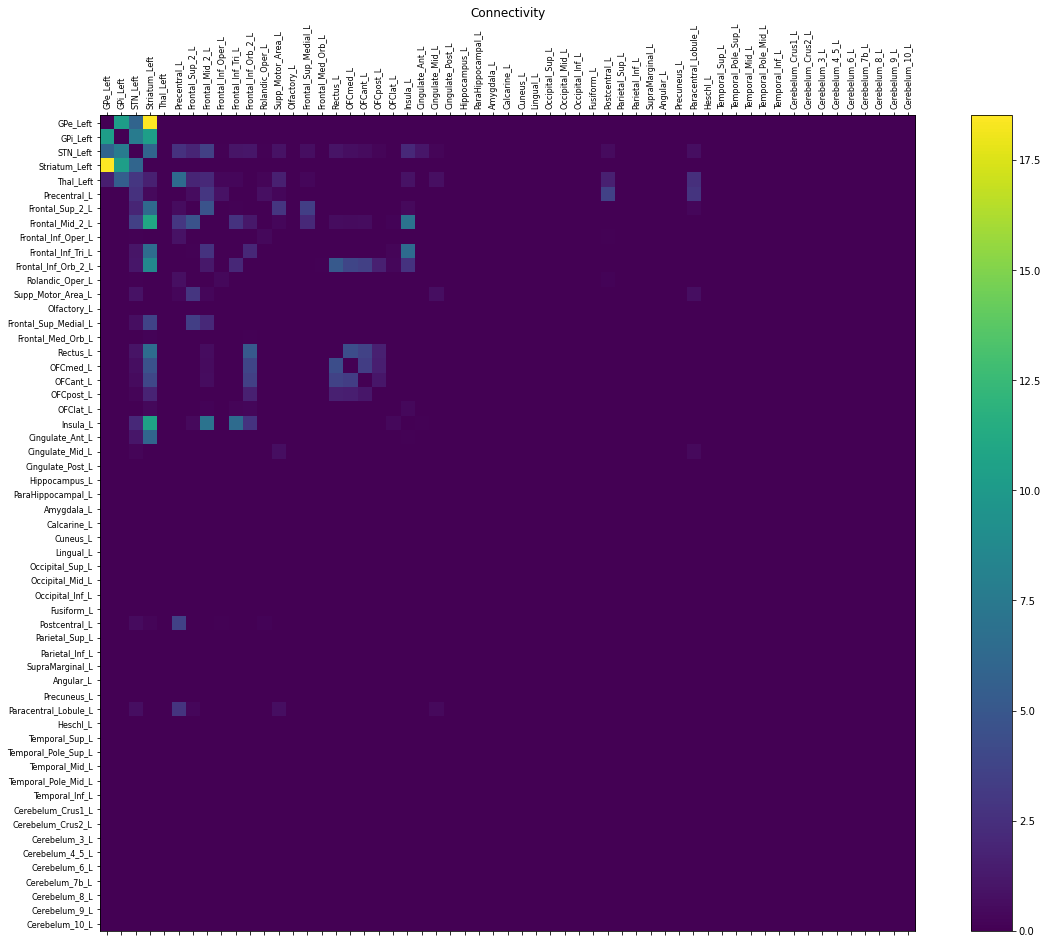

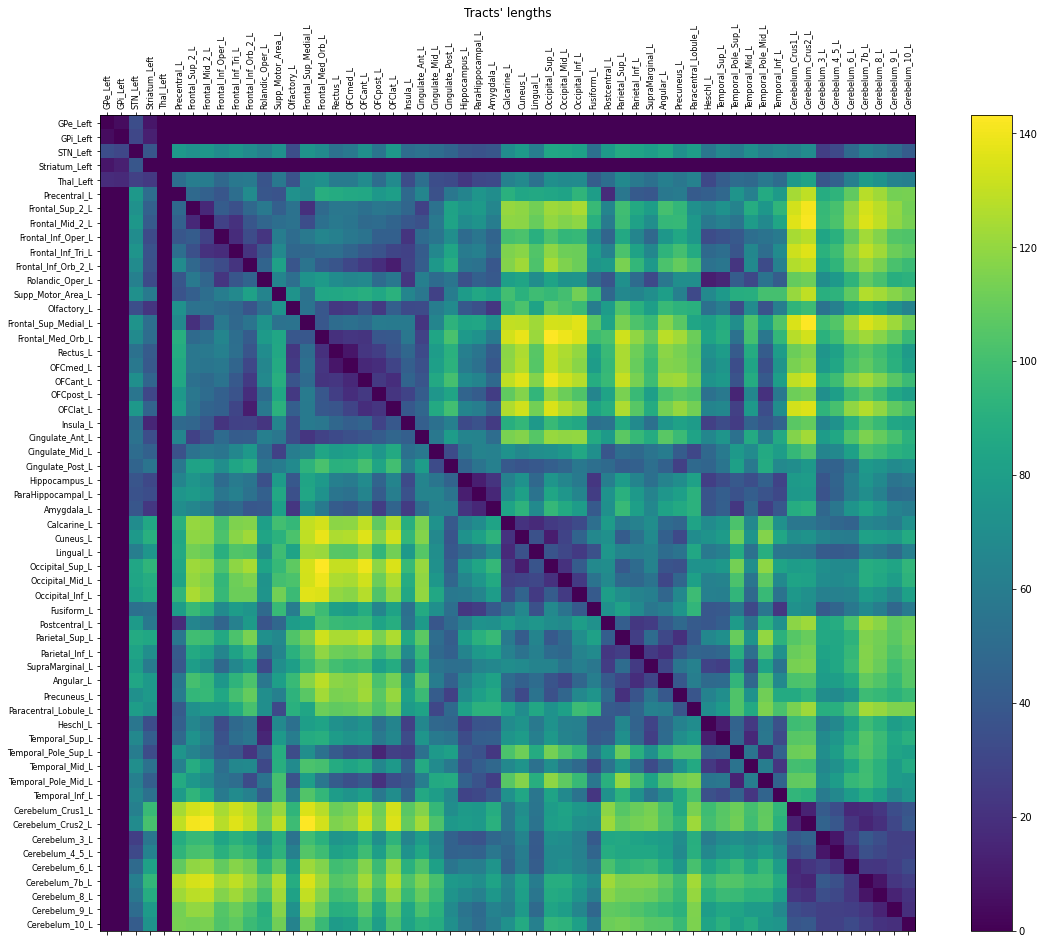

In [3]:
# Load full TVB connectome connectivity

conn_path = os.path.join(data_path, "basal_ganglia_conn")

#Load AAL atlas normative connectome including the Basal Ganglia regions from Petersen et al. atlas
wTVB = np.loadtxt(os.path.join(conn_path, "conn_denis_weights.txt"))
cTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),usecols=range(1,3))
rlTVB = np.loadtxt(os.path.join(conn_path, "aal_plus_BG_centers.txt"),dtype="str", usecols=(0,))
tlTVB = np.loadtxt(os.path.join(conn_path, "BGplusAAL_tract_lengths.txt"))

# Remove the second Thalamus, Pallidum (GPe/i), Putamen and Caudate (Striatum):
inds_Th = (rlTVB.tolist().index("Thalamus_L"), rlTVB.tolist().index("Thalamus_R"))
inds_Pall = (rlTVB.tolist().index("Pallidum_L"), rlTVB.tolist().index("Pallidum_R"))
inds_Put = (rlTVB.tolist().index("Putamen_L"), rlTVB.tolist().index("Putamen_R"))
inds_Caud = (rlTVB.tolist().index("Caudate_L"), rlTVB.tolist().index("Caudate_R"))
inds_rm = inds_Th + inds_Pall + inds_Put + inds_Caud
print("Connections of Thalami, Pallidum (GPe/i), Putamen and Caudate (Striatum) removed!:\n", 
      wTVB[inds_rm, :][:, inds_rm])
wTVB = np.delete(wTVB, inds_rm, axis=0)
wTVB = np.delete(wTVB, inds_rm, axis=1)
tlTVB = np.delete(tlTVB, inds_rm, axis=0)
tlTVB = np.delete(tlTVB, inds_rm, axis=1)
rlTVB = np.delete(rlTVB, inds_rm, axis=0)
cTVB = np.delete(cTVB, inds_rm, axis=0)

number_of_regions = len(rlTVB)
speed = np.array([4.0])
min_tt = speed.item() * 0.1
sliceBG = [0, 1, 2, 3, 6, 7]
sliceCortex = slice(10, number_of_regions)

# Remove BG -> Cortex connections
print("Removing BG -> Cortex connections with max:")
print(wTVB[sliceBG, :][:, sliceCortex].max())
wTVB[sliceBG, sliceCortex] = 0.0
tlTVB[sliceBG, sliceCortex] = min_tt

# Remove Cortex -> Thalamus connections
sliceThal = [8, 9]
print("Removing Cortex -> Thalamus connections with summed weight:")
print(wTVB[:, 4].sum())
wTVB[:, sliceThal] = 0.0
tlTVB[:, sliceThal] = min_tt

# Remove GPe/i <- Cortex connections
sliceBG = [0, 1, 2, 3]
print("Removing BG <- Cortex connections with max:")
print(wTVB[sliceCortex, :][:, sliceBG].max())
wTVB[sliceCortex, sliceBG] = 0.0
tlTVB[sliceCortex, sliceBG] = min_tt

connTVB = Connectivity(region_labels=rlTVB, weights=wTVB, centres=cTVB, tract_lengths=tlTVB, speed=speed)

# Normalize connectivity weights
connTVB.weights = connTVB.scaled_weights(mode="region")
connTVB.weights /= np.percentile(connTVB.weights, 99)

# Keep only left hemisphere and remove Vermis:
sliceLeft = slice(0, connTVB.number_of_regions -8, 2)

connLeft = Connectivity(region_labels=connTVB.region_labels[sliceLeft], 
                        centres=connTVB.centres[sliceLeft],
                        weights=connTVB.weights[sliceLeft][:, sliceLeft],
                        tract_lengths=connTVB.tract_lengths[sliceLeft][:, sliceLeft], 
                       speed=connTVB.speed)
connLeft.configure()

print("\nLeft cortex connectome, after removing direct BG -> Cortex and intehemispheric BG <-> BG connections:")
plotter.plot_tvb_connectivity(connLeft);



Left BG TVB network:


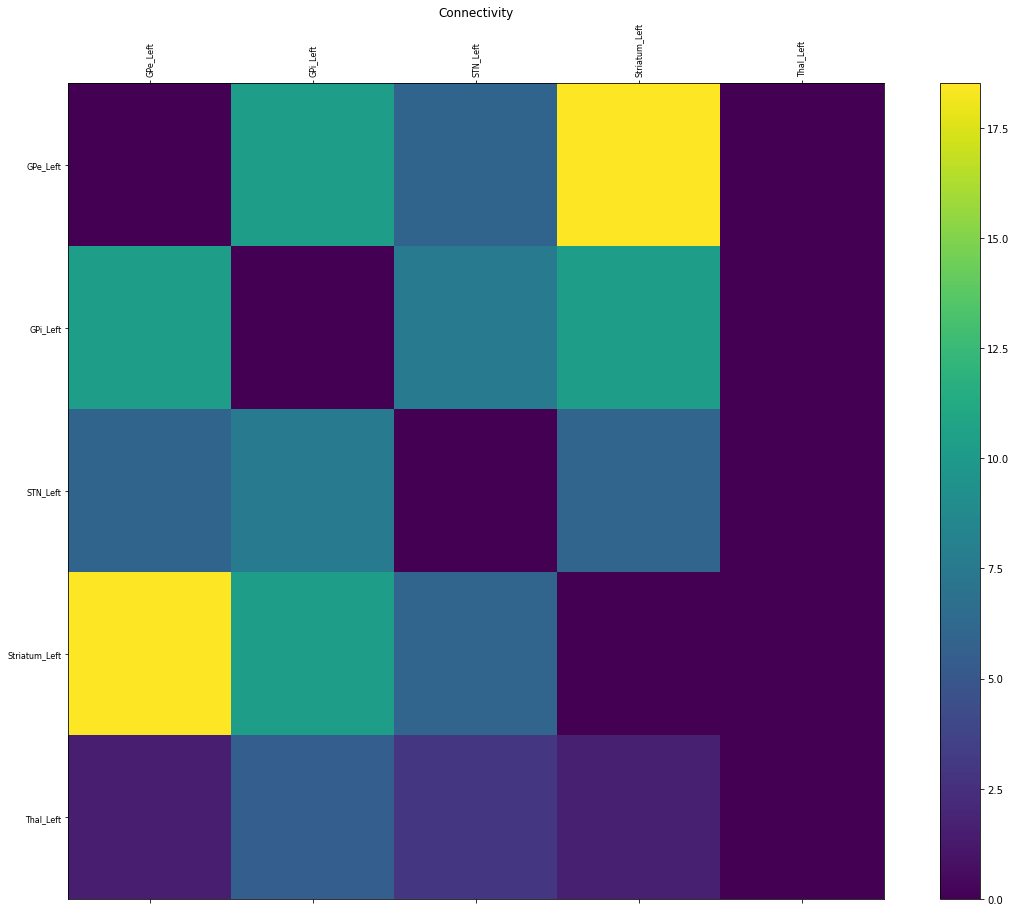

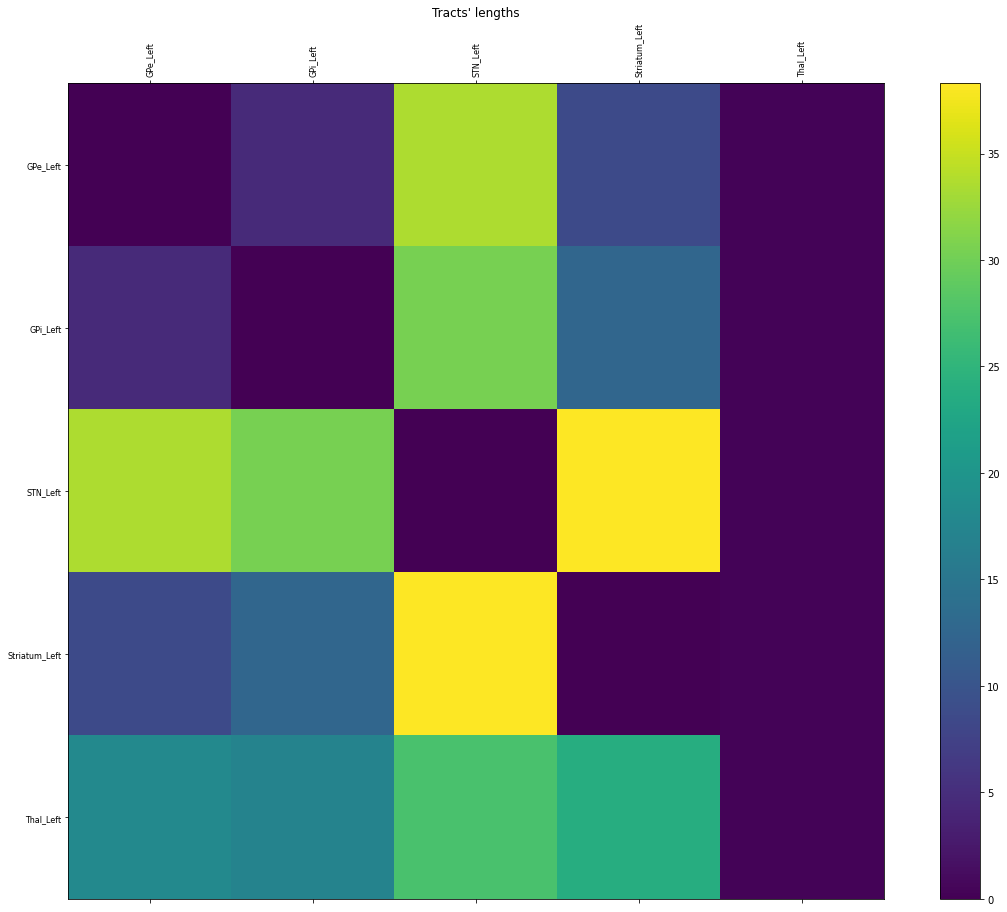

In [4]:
sliceBGnet = slice(0,5)
connTVBleftBG = Connectivity(region_labels=connLeft.region_labels[sliceBGnet], 
                             centres=connLeft.centres[sliceBGnet],
                             weights=connLeft.weights[sliceBGnet][:, sliceBGnet],
                             tract_lengths=connLeft.tract_lengths[sliceBGnet][:, sliceBGnet], 
                            speed=connLeft.speed)
connTVBleftBG.configure()

print("\nLeft BG TVB network:")
plotter.plot_tvb_connectivity(connTVBleftBG);


In [5]:
scaleBGoptTOtvb = np.percentile(BG_opt_matrix_weights, 95) /\
                  np.percentile(connTVBleftBG.weights, 95)
                  
print("Scaling factor of TVB BG network connectome to optimal one = %g" % scaleBGoptTOtvb)


Scaling factor of TVB BG network connectome to optimal one = 0.000709492



Left BG optimized network:


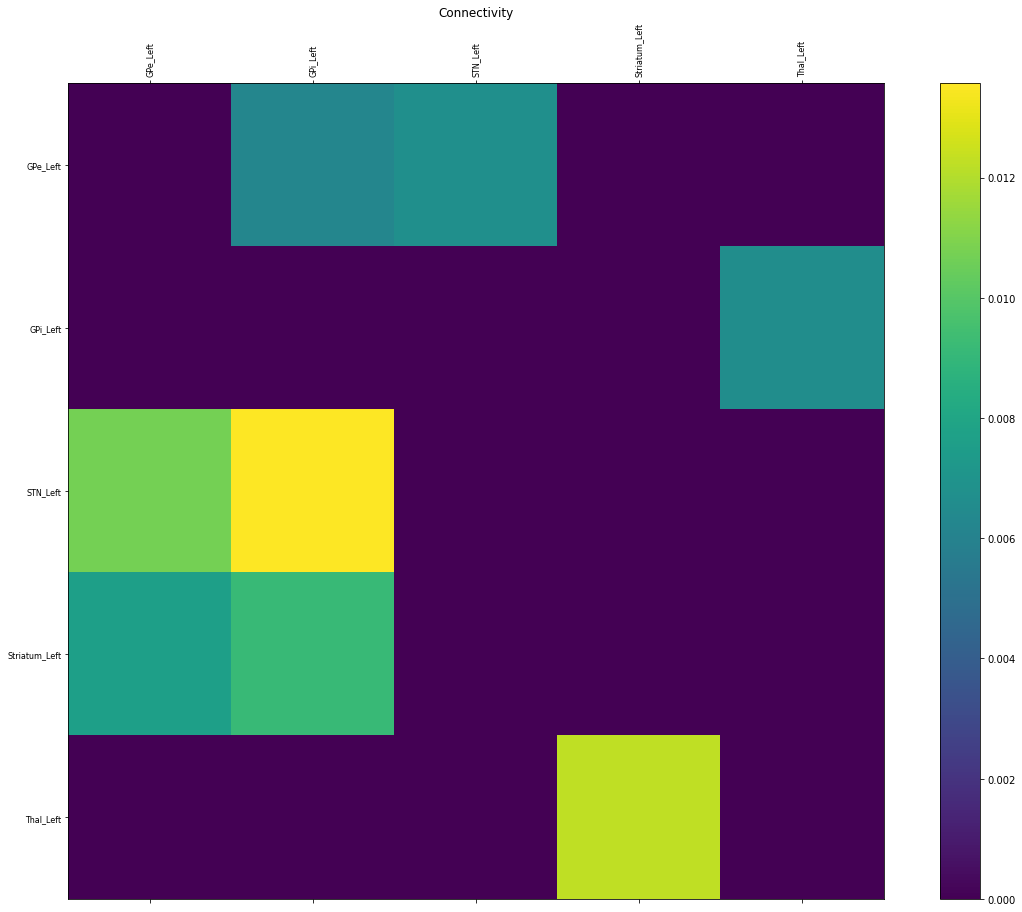

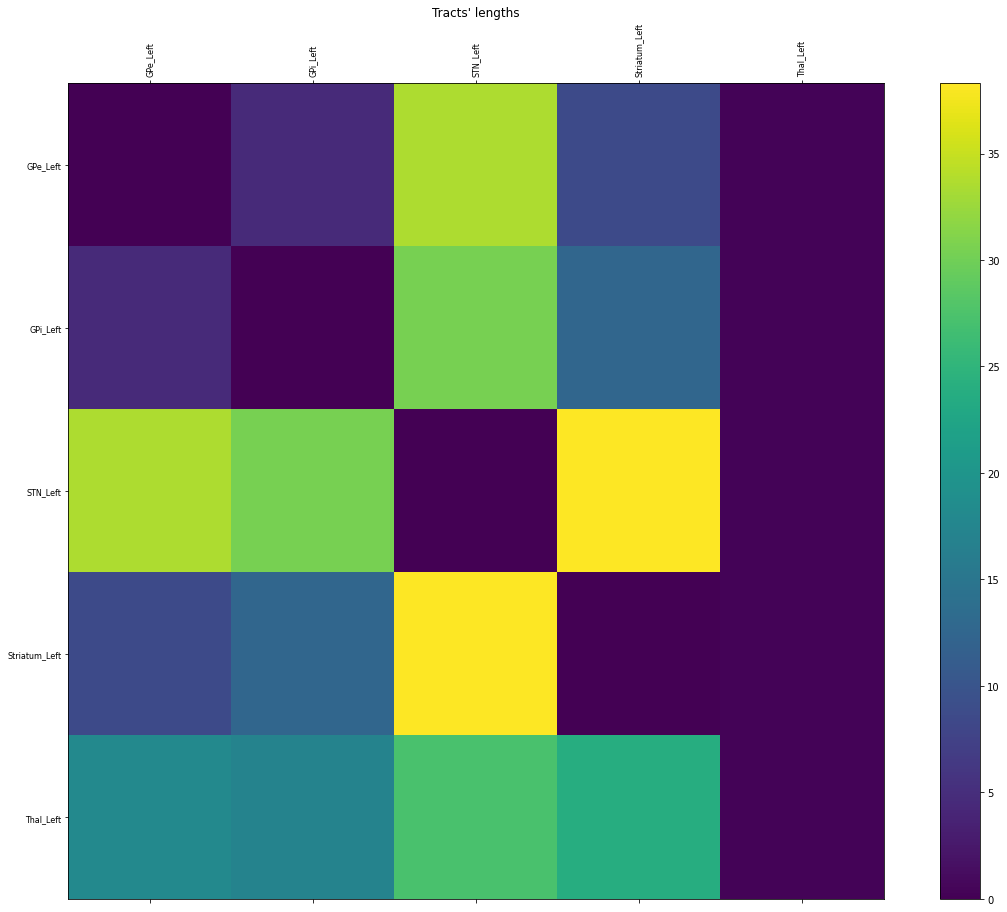

In [6]:
# Construct the final connectivity to use for simulation:
ww = scaleBGoptTOtvb * np.array(connLeft.weights)
ww[sliceBGnet, sliceBGnet] = BG_opt_matrix_weights

connectivity = Connectivity(region_labels=connLeft.region_labels, 
                            centres=connLeft.centres,
                            weights=ww, tract_lengths=connLeft.tract_lengths, 
                            speed=connLeft.speed)
connectivity.configure()

# Construct only the optimized BG connectivity only for plotting:
connBGopt = Connectivity(region_labels=connectivity.region_labels[sliceBGnet], 
                         centres=connectivity.centres[sliceBGnet],
                         weights=connectivity.weights[sliceBGnet][:, sliceBGnet],
                         tract_lengths=connectivity.tract_lengths[sliceBGnet][:, sliceBGnet], 
                         speed=connectivity.speed)
connBGopt.configure()

print("\nLeft BG optimized network:")
plotter.plot_tvb_connectivity(connBGopt);



Connectome used for simulations:


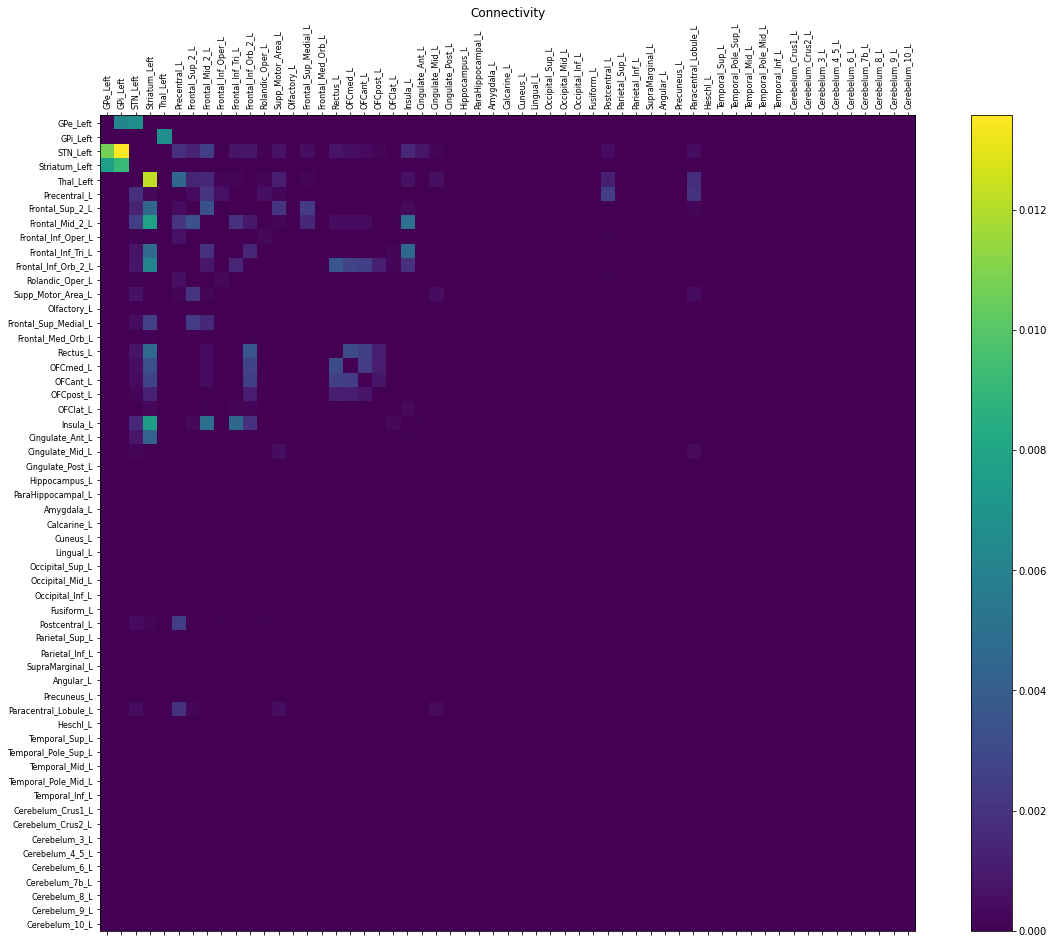

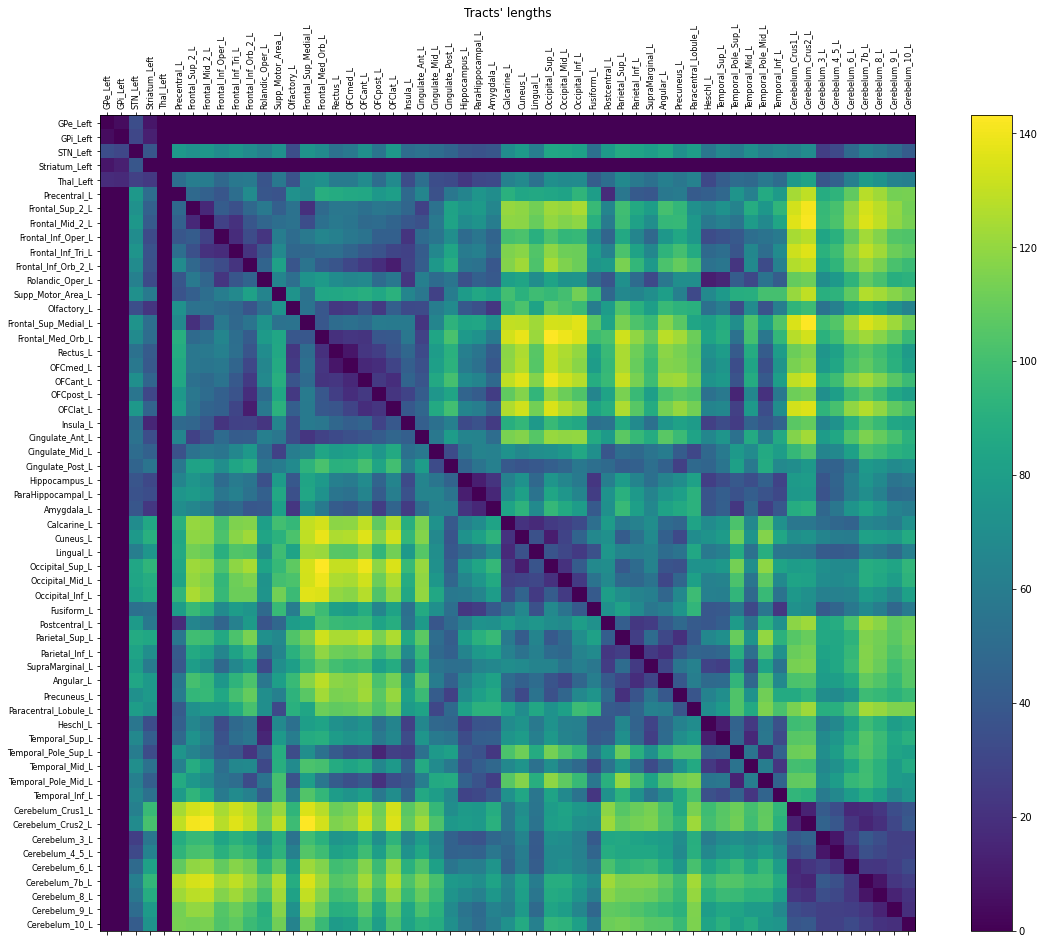

In [7]:
#white_matter_coupling = coupling.Linear(a=0.014)
# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
#simulator.use_numba = False
model_params = {"G": np.array([15.0/scaleBGoptTOtvb])}
simulator.model = ReducedWongWangExcIO(**model_params)

simulator.connectivity = connectivity

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([1e-5])

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

simulator.connectivity.set_idelays(simulator.integrator.dt)
simulator.horizon = simulator.connectivity.idelays.max() + 1

init_cond_filepath = os.path.join(outputs_path, "tvb_init_cond_left.npy")
init_cond = np.load(init_cond_filepath)  
simulator.initial_conditions = init_cond * np.ones((simulator.horizon,
                                                    simulator.model.nvar,
                                                    simulator.connectivity.number_of_regions,
                                                    simulator.model.number_of_modes))


print("\nConnectome used for simulations:")
plotter.plot_tvb_connectivity(simulator.connectivity);


## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [8]:
from tvb_multiscale.tvb_nest.nest_models.builders.models.basal_ganglia_izhikevich import BasalGangliaIzhikevichBuilder

# Select the regions for the fine scale modeling with NEST spiking networks
number_of_regions = simulator.connectivity.region_labels.shape[0]
#including cortex node:
nest_nodes_ids = [0, 1, 2, 3, 4]  #, 5 the indices of fine scale regions modeled with NEST

# Build a NEST network model with the corresponding builder
nest_model_builder = BasalGangliaIzhikevichBuilder(simulator, nest_nodes_ids, config=config)



# Using all default parameters for this example


# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
from copy import deepcopy

population_neuron_model = "izhikevich_hamker"

nest_model_builder.population_order = 200 # reduce for speed

# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

nest_model_builder.params_common = \
    {"V_m": -70.0, "U_m": -18.55, "E_rev_AMPA": 0.0, "E_rev_GABA_A": -90.0, "V_th": 30.0, "V_r": 0.0, "c": -65.0,
     "C_m": 1.0, "I_e": 0.0, "current_stimulus_scale": -25.0, "current_stimulus_mode": 2,
     "tau_rise": 1.0, "tau_rise_AMPA": 10.0, "tau_rise_GABA_A": 10.0,
     "n0": 140.0, "n1": 5.0, "n2": 0.04}

nest_model_builder._paramsI = deepcopy(nest_model_builder.params_common)
nest_model_builder._paramsI.update({"a": 0.005, "b": 0.585, "d": 4.0})
nest_model_builder._paramsE = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr = deepcopy(nest_model_builder.params_common)
nest_model_builder.paramsStr.update({"V_th": 40.0, "C_m": 50.0, "V_r": -80.0,
                                     "n0": 61.65, "n1": 2.59, "n2": 0.02, 
                                     "a": 0.05, "b": -20.0, "c": -55.0, "d": 377.0})

nest_model_builder.Igpe_nodes_ids = [0]
nest_model_builder.Igpi_nodes_ids = [1]
nest_model_builder.Estn_nodes_ids = [2]
nest_model_builder.Eth_nodes_ids = [4]
nest_model_builder.Istr_nodes_ids = [3]
#including cortex node:
# nest_model_builder.Crtx_nodes_ids = [5]

I_nodes_ids = nest_model_builder.Igpe_nodes_ids + nest_model_builder.Igpi_nodes_ids # + nest_model_builder.Crtx_nodes_ids
E_nodes_ids = nest_model_builder.Estn_nodes_ids + nest_model_builder.Eth_nodes_ids # + nest_model_builder.Crtx_nodes_ids


def paramsE_fun(node_id):
    paramsE = deepcopy(nest_model_builder._paramsE)
    if node_id in nest_model_builder.Estn_nodes_ids:
        paramsE.update({"a": 0.005, "b": 0.265, "d": 2.0, "I_e": 3.0})  # dictionary of params for Estn
    elif node_id in nest_model_builder.Eth_nodes_ids:
        paramsE.update({"a": 0.02, "b": 0.25, "d": 0.05, "I_e": 3.5}) # dictionary of params for Eth
    return paramsE
    
def paramsI_fun(node_id):
    # For the moment they are identical, unless you differentiate the noise parameters
    paramsI = deepcopy(nest_model_builder._paramsI)
    if node_id in nest_model_builder.Igpe_nodes_ids:
        paramsI.update({"I_e": 12.0})  # 12.0
    elif node_id in nest_model_builder.Igpi_nodes_ids:
        paramsI.update({"I_e": 30.0})  # 30.0
    return paramsI
    
# Populations' configurations
# When any of the properties model, params and scale below depends on regions,
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property
nest_model_builder.populations = [
    {"label": "E", "model": population_neuron_model,  
     "params":  paramsE_fun, 
     "nodes": E_nodes_ids,  # Estn in [2], Eth in [4]
     "scale": 1.0}, 
    {"label": "I", "model": population_neuron_model,  
     "params": paramsI_fun, 
     "nodes": I_nodes_ids,  # Igpe in [0], Igpi in [1]
     "scale": 1.0}, 
    {"label": "IdSN", "model": population_neuron_model,   
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # IdSN in [3]
     "scale": 1.0},
    {"label": "IiSN", "model": population_neuron_model,   # IiSN in [3]
     "params": nest_model_builder.paramsStr, 
     "nodes": nest_model_builder.Istr_nodes_ids,  # None means "all"
     "scale": 1.0}
]


# NOTE!!! TAKE CARE OF DEFAULT simulator.coupling.a!
# nest_model_builder.global_coupling_scaling = nest_model_builder.tvb_simulator.coupling.a[0].item() 
nest_model_builder.global_coupling_scaling = 1.0 # nest_model_builder.coupling_a 
# if we use Reduced Wong Wang model, we also need to multiply with the global coupling constant G:
# nest_model_builder.global_coupling_scaling *= nest_model_builder.tvb_simulator.model.G[0].item()


# Within region-node connections
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# set a handle to a function with
# arguments (region_index=None) returning the corresponding property

synapse_model = "static_synapse"
conn_spec = {"allow_autapses": True, "allow_multapses": True, 'rule': "all_to_all",
             "indegree": None, "outdegree": None, "N": None, "p": 0.1}
conn_spec_bernoulli = conn_spec.copy()
conn_spec_bernoulli.update({'rule': "pairwise_bernoulli"})

def conn_spec_prob(p=None):
    output = conn_spec_bernoulli.copy()
    if p is not None:
        output["p"] = p
    return output

within_node_delay = 1.0
        

# for each connection, we have a different probability
nest_model_builder.populations_connections = [
# #      #        source   ->   target
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeGPe),  # conn_spec
     "weight": -np.abs(wGPeGPe), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Igpe_nodes_ids,
    },  # None means apply to all
    {"source": "I", "target": "I",  # I -> I This is a self-connection for populations "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPiGPi),  # conn_spec
     "weight": -np.abs(wGPiGPi), "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Igpi_nodes_ids,
    },  # None means apply to all
    {"source": "IdSN", "target": "IdSN",  # IdSN -> IdSN This is a self-connection for population "IdSN"
     "model": synapse_model, "conn_spec": conn_spec_prob(pdSNdSN),  # conn_spec
     "weight": -wdSNdSN, "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    {"source": "IiSN", "target": "IiSN",  # IiSN -> IiSN This is a self-connection for population "IiSN"
     "model": synapse_model, "conn_spec": conn_spec_prob(piSNiSN),  # conn_spec
     "weight": -wiSNiSN, "delay": within_node_delay,
     "receptor_type": 0, "nodes": nest_model_builder.Istr_nodes_ids},
    ]



# Among/Between region-node connections
# Given that only the AMPA population of one region-node couples to
# all populations of another region-node,
# we need only one connection type
        
# When any of the properties model, conn_spec, weight, delay, receptor_type below
# depends on regions, set a handle to a function with
# arguments (source_region_index=None, target_region_index=None)

from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

        
class TVBWeightFun(object):
    tvb_weights = nest_model_builder.tvb_weights
    global_coupling_scaling = nest_model_builder.global_coupling_scaling
    sign = 1

    def __init__(self, sign=1, scale=nest_model_builder.global_coupling_scaling):
        self.sign = sign
        self.global_coupling_scaling = scale * self.sign
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)
    
tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(nest_model_builder.tvb_dt, tvb_delay(source_node, target_node, nest_model_builder.tvb_delays))

# Total excitatory spikes of one region node will be distributed to
nest_model_builder.nodes_connections = [
#     #        source    ->     target
    {"source": "IdSN", "target": "I",             # "IdSN" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pdSNGPi),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "IiSN", "target": "I",            # "IiSN" -> "Igpe"
     "model": synapse_model, "conn_spec": conn_spec_prob(piSNGPe),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Istr_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},  # None means apply to all
    {"source": "I", "target": "I",             # "Igpe" -> "Igpi"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeGPi),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",              # "Igpi" -> "Eth"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPiTh),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpi_nodes_ids, 
     "target_nodes": nest_model_builder.Eth_nodes_ids},  # None means apply to all
    {"source": "I", "target": "E",             # "Igpe" -> "Estn"
     "model": synapse_model, "conn_spec": conn_spec_prob(pGPeSTN),  # conn_spec
     "weight": TVBWeightFun(-1),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Igpe_nodes_ids, 
     "target_nodes": nest_model_builder.Estn_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IdSN",   # "Eth" -> ["IdSN"] 
     "model": synapse_model, "conn_spec": conn_spec_prob(pThdSN),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # None means apply to all
    {"source": "E", "target": "IiSN",   # "Eth" -> ["IiSN"] 
     "model": synapse_model, "conn_spec": conn_spec_prob(pThiSN),  # conn_spec
     "weight": wThiSN,
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Eth_nodes_ids, 
     "target_nodes": nest_model_builder.Istr_nodes_ids},  # No
    {"source": "E", "target": "I",          # "Estn" -> ["Igpe"]
     "model": synapse_model, "conn_spec": conn_spec_prob(pSTNGPe),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpe_nodes_ids},
    {"source": "E", "target": "I",          # "Estn" -> ["Igpi"]
     "model": synapse_model, "conn_spec": conn_spec_prob(pSTNGPi),  # conn_spec
     "weight": TVBWeightFun(),
     "delay": lambda source_node, target_node: tvb_delay_fun(source_node, target_node),  
     "receptor_type": 0, 
     "source_nodes": nest_model_builder.Estn_nodes_ids, 
     "target_nodes": nest_model_builder.Igpi_nodes_ids},
     ]

# Creating  devices to be able to observe NEST activity:

nest_model_builder.output_devices = []

#          label <- target population
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"] + "_spikes"] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "spike_recorder", "params": {"record_to": "memory"},
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to "all"

# Labels have to be different

connections = OrderedDict({})
#               label    <- target population
params = {"interval": 1.0, "record_to": "memory",
          'record_from': ["V_m", "U_m", "I", "I_syn", "I_syn_ex", "I_syn_in", "g_AMPA", "g_GABA_A", "g_L"]}
for pop in nest_model_builder.populations:
    connections = OrderedDict({})
    connections[pop["label"]] = pop["label"]
    nest_model_builder.output_devices.append(
        {"model": "multimeter", "params": params,
         "connections": connections, "nodes": pop["nodes"]})  # None means apply to all
    

#Create a spike stimulus input device
# #including cortex node: we do not need any other external stimulation
# nest_model_builder.Estn_stim = {"rate": 500.0, "weight": 0.009}
# nest_model_builder.Igpe_stim = {"rate": 100.0, "weight": 0.015}
# nest_model_builder.Igpi_stim = {"rate": 700.0, "weight": 0.02}
nest_model_builder.input_devices = [
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Estn_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineEstn": ["E"]},  # "Estn"
#      "nodes": nest_model_builder.Estn_nodes_ids,  # "Estn"
#      "weights": nest_model_builder.Estn_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpe_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpe": ["I"]},  # "Igpe"
#      "nodes": nest_model_builder.Igpe_nodes_ids,  # "Igpe"
#      "weights": nest_model_builder.Igpe_stim["weight"], "delays": 0.0, "receptor_type": 1},
#     {"model": "poisson_generator",
#      "params": {"rate": nest_model_builder.Igpi_stim["rate"], "origin": 0.0, "start": 0.1},
#      "connections": {"BaselineIgpi": ["I"]},  # "Igpi"
#      "nodes": nest_model_builder.Igpi_nodes_ids,  ## "Igpi"
#      "weights": nest_model_builder.Igpi_stim["weight"], "delays": 0.0, "receptor_type": 1},
#      {"model": "dc_generator",
#      "params": { "amplitude": 1.0, #"frequency": 20.0, "phase": 0.0,"offset": 0.0,
#                 "start": 200.0, "stop": 450.0 },  # "stop": 100.0  "origin": 0.0, 
#      "connections": {"DBS_GPi": ["I"]}, # "GPi"
#      "nodes": nest_model_builder.Igpi_nodes_ids, # "GPi"
#      "weights": 1.0, "delays": 0.0}
#         {"model": "dc_generator",
#          "params": { "amplitude": 2.0, #"frequency": 20.0, "phase": 0.0,"offset": 0.0,
#                     "start": 200.0, "stop": 450.0 },  # "stop": 100.0  "origin": 0.0, 
#          "connections": {"DBS_STN": ["E"]}, # "STN"
#          "nodes": nest_model_builder.Estn_nodes_ids, # "STN"
#          "weights": 1.0, "delays": 0.0}
       ]  #

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------


nest_network = nest_model_builder.build_spiking_network()


2021-03-10 14:30:37,734 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2021-03-10 14:30:37,734 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module izhikevich_hamkermodule...
2021-03-10 14:30:37,762 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-03-10 14:30:37,762 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module izhikevich_hamkermodule!
2021-03-10 14:30:37,850 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-03-10 14:30:37,850 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_recorder for E_spikes created!
2021-03-10 14:30:37,942 - INFO - tvb_multiscale.core.spiking_models.devices - <class '

In [9]:
populations_sizes = []
print("Population sizes: ")
for pop in nest_model_builder.populations:
    populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
    print("%s: %d" % (pop["label"], populations_sizes[-1]))
    
# print(nest_network.print_str(connectivity=True))


Population sizes: 
E: 200
I: 200
IdSN: 200
IiSN: 200


In [10]:
# print(nest_network.print_str(connectivity=True))
print("Within node's connections:")
for pop in nest_model_builder.populations_connections:
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["nodes"])
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["p"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    
    print("%s -> %s (%d) = %g (p=%g): %s (%g, %g)" 
          % (pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))
    
print("\nAmong node's connections:")
for pop in nest_model_builder.nodes_connections:
    if hasattr(pop["weight"], "__call__"):
        weight = pop["weight"](pop["source_nodes"], pop["target_nodes"]).item()
    else:
        weight = pop["weight"]
    try:
        p = pop["conn_spec"]["p"]
    except:
        p = 1.0
    w_conn = assert_loadedParams[np.abs(weight)]
    conn = w_conn.split("_weights")[0]
    p_conn = loadedParams["%s_probs" % conn]
    w_conn = loadedParams[w_conn]
    print("%s -> %s (%d) = %g (p=%g): %s (%g, %g)" 
          % (pop["source"], pop["target"], pop["receptor_type"], weight, p,
             conn, w_conn, p_conn))

Within node's connections:
I -> I (0) = -0.00773167 (p=0.323896): GPeGPe (0.00773167, 0.323896)
I -> I (0) = -0.0119856 (p=0.317476): GPiGPi (0.0119856, 0.317476)
IdSN -> IdSN (0) = -0.0081135 (p=0.44881): dSNdSN (0.0081135, 0.44881)
IiSN -> IiSN (0) = -0.0139626 (p=0.204922): iSNiSN (0.0139626, 0.204922)

Among node's connections:
IdSN -> I (0) = -0.00913217 (p=0.170292): dSNGPi (0.00913217, 0.170292)
IiSN -> I (0) = -0.00766353 (p=0.407464): iSNGPe (0.00766353, 0.407464)
I -> I (0) = -0.0062383 (p=0.323173): GPeGPi (0.0062383, 0.323173)
I -> E (0) = -0.00665013 (p=0.259374): GPiThal (0.00665013, 0.259374)
I -> E (0) = -0.00676034 (p=0.184785): GPeSTN (0.00676034, 0.184785)
E -> IdSN (0) = 0.0122845 (p=0.127913): ThaldSN (0.0122845, 0.127913)
E -> IiSN (0) = 0.00698403 (p=0.175348): ThaliSN (0.00698403, 0.175348)
E -> I (0) = 0.0107546 (p=0.411954): STNGPe (0.0107546, 0.411954)
E -> I (0) = 0.0135662 (p=0.245841): STNGPi (0.0135662, 0.245841)


## 3. Build the TVB-NEST interface

In [11]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.red_ww_basal_ganglia_izhikevich import RedWWexcIOBuilder

    
# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    RedWWexcIOBuilder(simulator, nest_network, nest_nodes_ids, 
                      exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = "rate"
nest_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> NEST


# --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------

# tvb_nest_builder.G = tvb_nest_builder.tvb_simulator.model.G[0].item()
# tvb_nest_builder.global_coupling_scaling = tvb_nest_builder.tvb_simulator.coupling.a[0].item() * tvb_nest_builder.G
tvb_nest_builder.global_coupling_scaling = 0.2

class TVBWeightFun(object):
    tvb_weights = nest_model_builder.tvb_weights
    global_coupling_scaling = nest_model_builder.global_coupling_scaling
    
    def __init__(self, scale=nest_model_builder.global_coupling_scaling):
        self.tvb_weights = nest_model_builder.tvb_weights
        self.global_coupling_scaling = scale
        
    def __call__(self, source_node, target_node):
        return scale_tvb_weight(source_node, target_node, self.tvb_weights,
                                scale=self.global_coupling_scaling)

tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_nest_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_nest_builder.tvb_delays))

# Total TVB weight to STN:
wTVBSTNs = simulator.connectivity.weights[5:, nest_model_builder.Estn_nodes_ids].squeeze()
wTVBSTN = wTVBSTNs.sum()
print("wTVBSTN = %g" % wTVBSTN)
# Total TVB weight to Striatum:
wTVBSNs = simulator.connectivity.weights[5:, nest_model_builder.Istr_nodes_ids].squeeze()
wTVBSN = wTVBSNs.sum()
print("wTVBSN = %g" % wTVBSN)

iwCtxSTN = wCtxSTN / wTVBSTN
print("iwCtxSTN = %g" % iwCtxSTN)
print("wCtxSTN_effective = iwCtxSTN * wTVBSTN = %g = wCtxSTN = %g" % (iwCtxSTN * wTVBSTN, wCtxSTN))
# It has to be:
# # wCtxSTN / wCtxdSN = (iwCtxSTN * wTVBSTN) / (iwCtxdSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxdSN = wCtxdSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for dSN
iwCtxdSN = wCtxdSN / wTVBSN  # 10*
print("iwCtxdSN = %g" % iwCtxdSN)
print("wCtxdSN_effective = iwCtxdSN * wTVBSN = %g = wCtxdSN = %g" % (iwCtxdSN * wTVBSN, wCtxdSN))
# # wCtxSTN / wCtxiSN = (iwCtxSTN * wTVBSTN) / (iwCtxiSN * wTVBSN) => (solving for iwCtxiSN)
# iwCtxiSN = wCtxiSN * iwCtxSTN * wTVBSTN / (wCtxSTN * wTVBSN) / 100 # interface weight for iSN
iwCtxiSN = wCtxiSN / wTVBSN  # 
print("iwCtxiSN = %g" % iwCtxiSN)
print("wCtxiSN_effective = iwCtxiSN * wTVBSN = %g = wCtxiSN = %g" % (iwCtxiSN * wTVBSN, wCtxiSN))


tvb_nest_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_nest_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons
    for trg_pop, target_nodes, conn_scaling, this_conn_spec in zip(["E", "IdSN", "IiSN"],
                                                     [nest_model_builder.Estn_nodes_ids, 
                                                      nest_model_builder.Istr_nodes_ids, 
                                                      nest_model_builder.Istr_nodes_ids],  
                                                     [iwCtxSTN, iwCtxdSN, iwCtxiSN], # [wCtxSTN/52, wCtxdSN/52, wCtxiSN/52],
                                                     [conn_spec_prob(p=pCtxSTN), # pCtxSTN  
                                                      conn_spec_prob(p=pCtxdSN), # pCtxdSN
                                                      conn_spec_prob(p=pCtxiSN)] # pCtxiSN
                                                      ):
        tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "parrot_inhomogeneous_poisson_generator",  # parrot_
             "params": {"allow_offgrid_times": False, "number_of_neurons": 600, 
                        "record": {"record_to": "memory"}},
        # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": 1.0, 
        # Applied outside NEST for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)--------
             "weights": TVBWeightFun(scale=conn_scaling*tvb_nest_builder.global_coupling_scaling),
             "delays": lambda tvb_node_id, nest_node_id: tvb_delay_fun(tvb_node_id, nest_node_id),
             "receptor_type": 0,
             "conn_spec": this_conn_spec,
        # -------------------------------------------------------------------------------------------------------------
        #             TVB sv -> NEST population
             "connections": {"R": trg_pop},
             "source_nodes": None, "target_nodes": target_nodes})  # None means all here

    
if nest_to_tvb:
    tvb_nest_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- NEST:
    for src_pop, nodes in zip(["I",         "E",         ["IdSN", "IiSN"]],
                              [I_nodes_ids, E_nodes_ids, nest_model_builder.Istr_nodes_ids]):
        #            TVB <- NEST
        tvb_nest_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "spike_recorder", "params": {},
        # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
             "interface_weights": 1.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------
             "connections": {"Rin": src_pop}, "nodes": nodes})  # None means all here
    #            TVB <- NEST
    
tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# We return from a NEST spike_recorder the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_nest_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)


wTVBSTN = 0.0138205
wTVBSN = 0.0506763
iwCtxSTN = 0.928525
wCtxSTN_effective = iwCtxSTN * wTVBSTN = 0.0128327 = wCtxSTN = 0.0128327
iwCtxdSN = 0.194195
wCtxdSN_effective = iwCtxdSN * wTVBSN = 0.0098411 = wCtxdSN = 0.0098411
iwCtxiSN = 0.210571
wCtxiSN_effective = iwCtxiSN * wTVBSN = 0.010671 = wCtxiSN = 0.010671
2021-03-10 14:30:40,042 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:30:40,042 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:30:40,046 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:30:40,046 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2021-03-10 14:30:40,061 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.c

In [12]:
# print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))


## 4. Configure simulator, simulate, gather results

In [13]:
# Configure the simulator with the TVB-NEST interface...
simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
# ...and simulate!
t = time.time()
simulation_length=550.0
transient = 50.0 # simulation_length/11
results = simulator.run(simulation_length=simulation_length)
# Integrate NEST one more NEST time step so that multimeters get the last time point
# unless you plan to continue simulation later
simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
print("\nSimulated in %f secs!" % (time.time() - t))

...10.0% done in 51.8 sec
...20.0% done in 102.8 sec
...30.0% done in 154.9 sec
...40.0% done in 202.5 sec
...50.0% done in 247.3 sec
...60.0% done in 294.4 sec
...70.0% done in 365.8 sec
...80.0% done in 435.8 sec
...90.0% done in 506.2 sec
...100.0% done in 576.5 sec

Simulated in 576.623046 secs!


In [14]:
# Clean-up NEST simulation
simulator.tvb_spikeNet_interface.nest_instance.Cleanup()

## 5. Plot results and write them to HDF5 files

In [15]:
# set to False for faster plotting of only mean field variables and dates, apart from spikes" rasters:
plot_per_neuron = False  
MAX_VARS_IN_COLS = 3
MAX_REGIONS_IN_ROWS = 10
MIN_REGIONS_FOR_RASTER_PLOT = 9
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables", 
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, 
#                    plot_per_neuron=plot_per_neuron, plotter=plotter, config=config)

In [16]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
        data=results[0][1], time=results[0][0],
        connectivity=simulator.connectivity,
        labels_ordering=["Time", "State Variable", "Region", "Neurons"],
        labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                           "Region": simulator.connectivity.region_labels.tolist()},
        sample_period=simulator.integrator.dt)
source_ts.configure()

t = source_ts.time - source_ts.time[0]
    
# Write to file
if writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                    connectivity=source_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
source_ts


init_cond = source_ts[-100:]._data.values.mean(axis=0)
init_cond[2:] = 0.0
init_cond[1:, 5:] = 0.0
np.save(init_cond_filepath, init_cond)


In [17]:
TVBrate = source_ts[transient:][:, "R", 5:]._data.values.mean(axis=0).squeeze()
TVBrateSTN = TVBrate * iwCtxSTN * wTVBSTNs * tvb_nest_builder.global_coupling_scaling
TVBratedSN = TVBrate * iwCtxdSN * wTVBSNs  * tvb_nest_builder.global_coupling_scaling
TVBrateiSN = TVBrate * iwCtxiSN * wTVBSNs  * tvb_nest_builder.global_coupling_scaling
mean_tvb_rate = TVBrate.mean()
total_tvb_rate = TVBrate.sum()
print("Mean TVB rate = %g" % mean_tvb_rate)
print("Total TVB rate = %g" % total_tvb_rate)
print("Total weighted TVB rate to STN = %g ~= %g (expected) ~= %g (Maith et al)" % 
          (TVBrateSTN.sum(), mean_tvb_rate*iwCtxSTN * wTVBSTN, mean_tvb_rate*wCtxSTN))
print("Total weighted TVB rate to dSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBratedSN.sum(), mean_tvb_rate* iwCtxdSN * wTVBSN, mean_tvb_rate*wCtxdSN))
print("Total weighted TVB rate to iSN = %g ~= %g (expected) ~= %g (Maith et al)" 
          % (TVBrateiSN.sum(), mean_tvb_rate*iwCtxiSN * wTVBSN,  mean_tvb_rate*wCtxiSN))

2021-03-10 14:40:28,379 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
Mean TVB rate = 16.7633
Total TVB rate = 871.689
Total weighted TVB rate to STN = 0.0837637 ~= 0.215117 (expected) ~= 0.215117 (Maith et al)
Total weighted TVB rate to dSN = 0.0714931 ~= 0.164969 (expected) ~= 0.164969 (Maith et al)
Total weighted TVB rate to iSN = 0.0775218 ~= 0.17888 (expected) ~= 0.17888 (Maith et al)


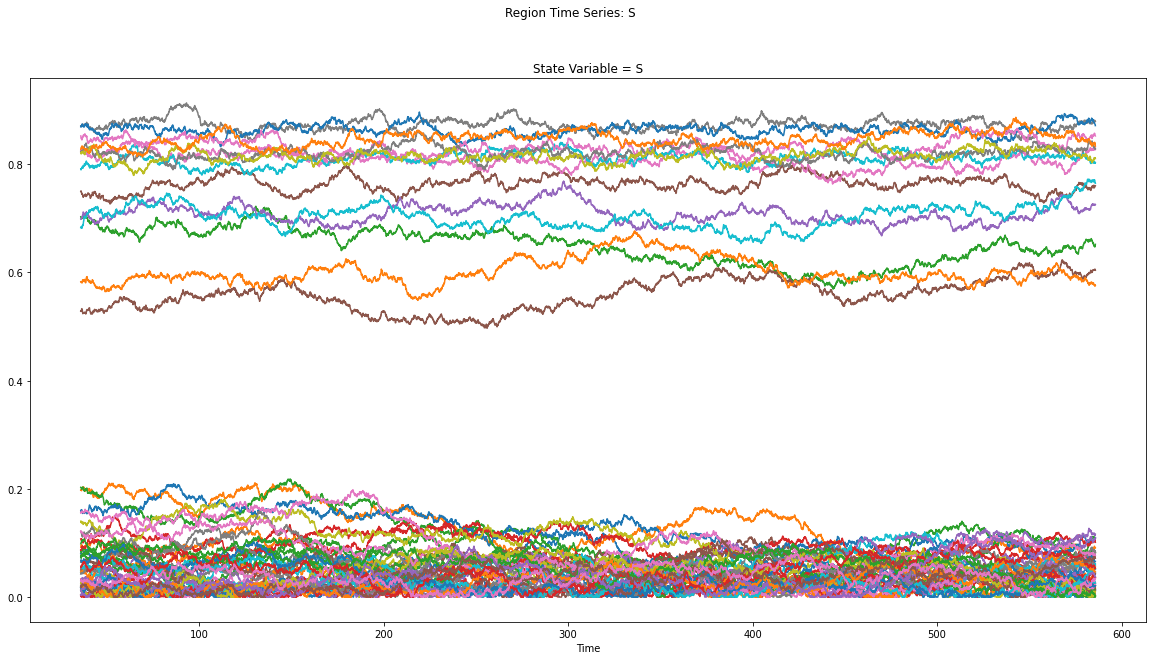

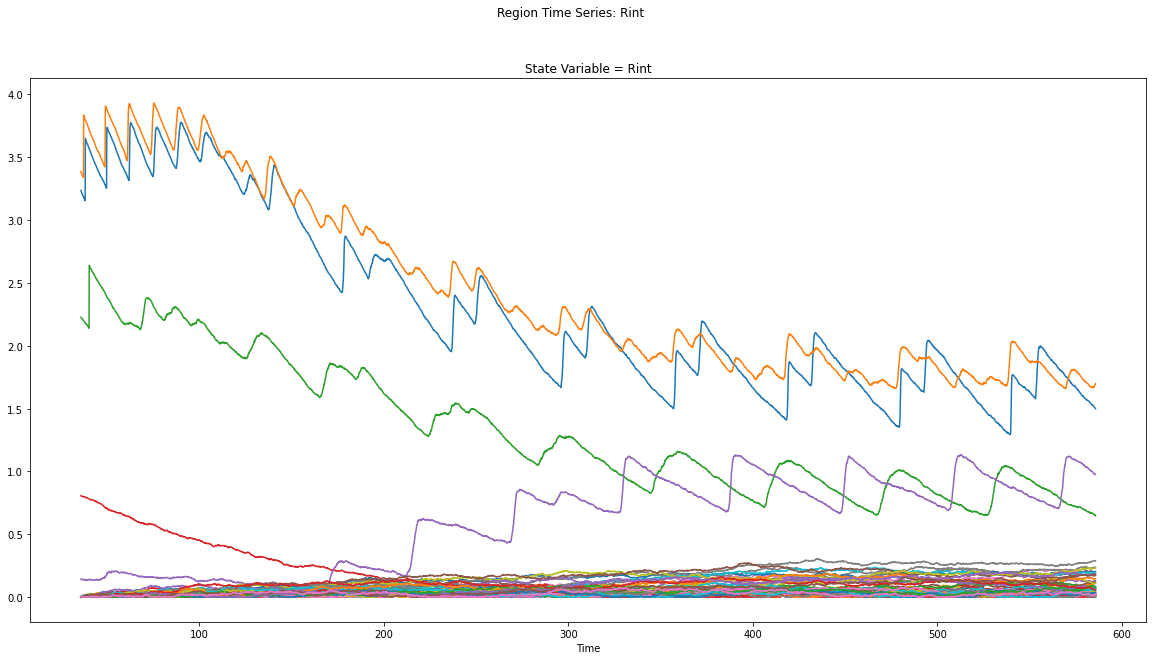

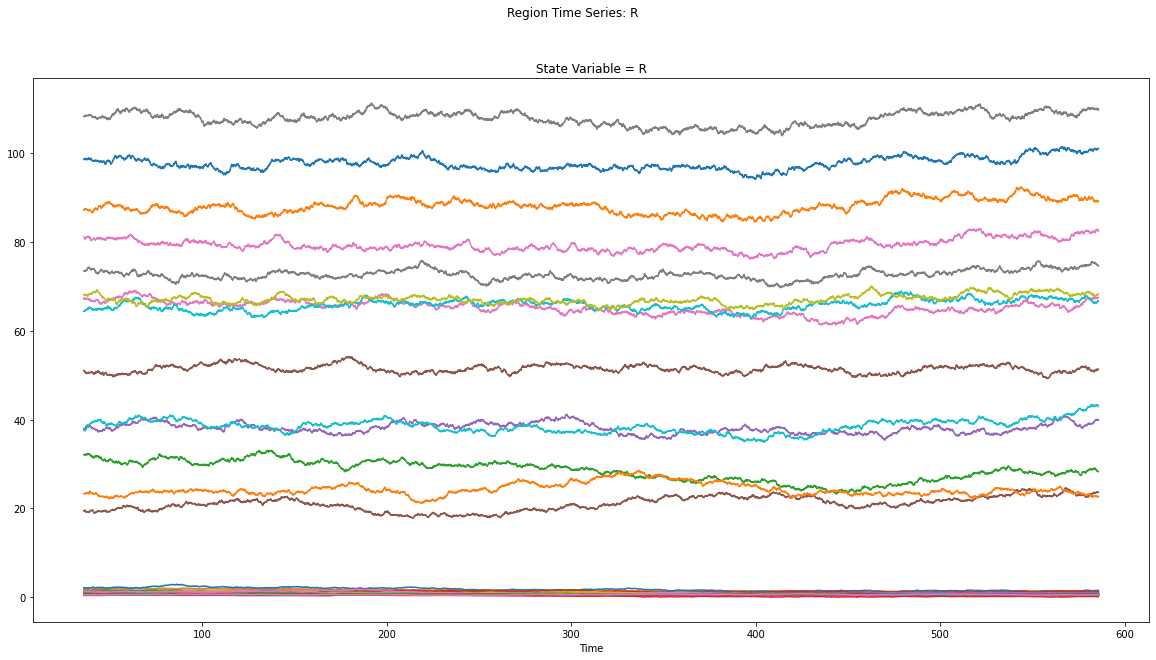

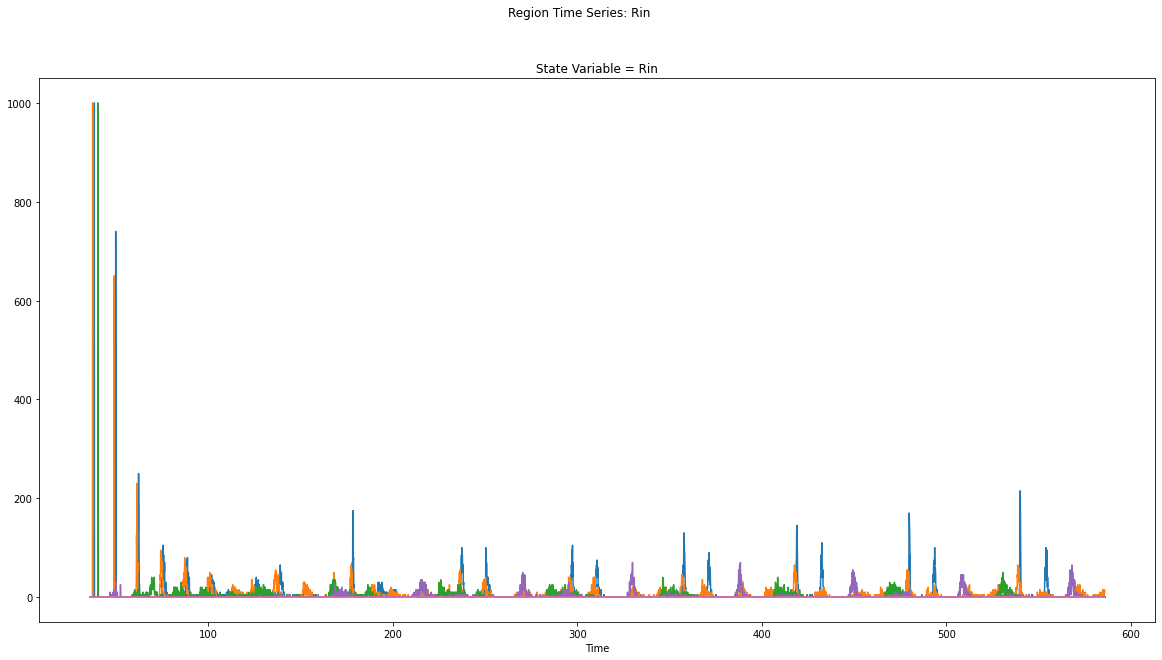

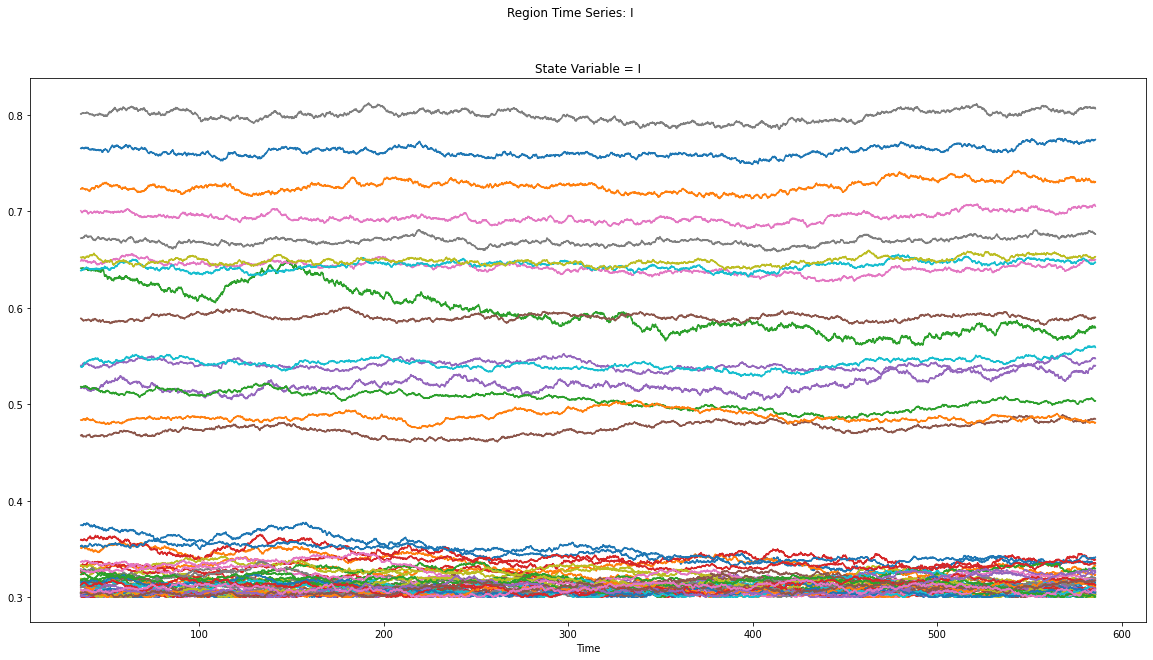

In [18]:
# Plot TVB time series
source_ts.plot_timeseries(plotter_config=plotter.config, 
                          hue="Region" if source_ts.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                          per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS, 
                          figsize=FIGSIZE);

In [19]:
# # TVB time series raster plot:
# if source_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts.plot_raster(plotter_config=plotter.config, 
#                           per_variable=source_ts.shape[1] > MAX_VARS_IN_COLS,
#                           figsize=FIGSIZE);

2021-03-10 14:40:33,681 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:33,707 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:34,606 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:35,294 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:35,986 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:36,632 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


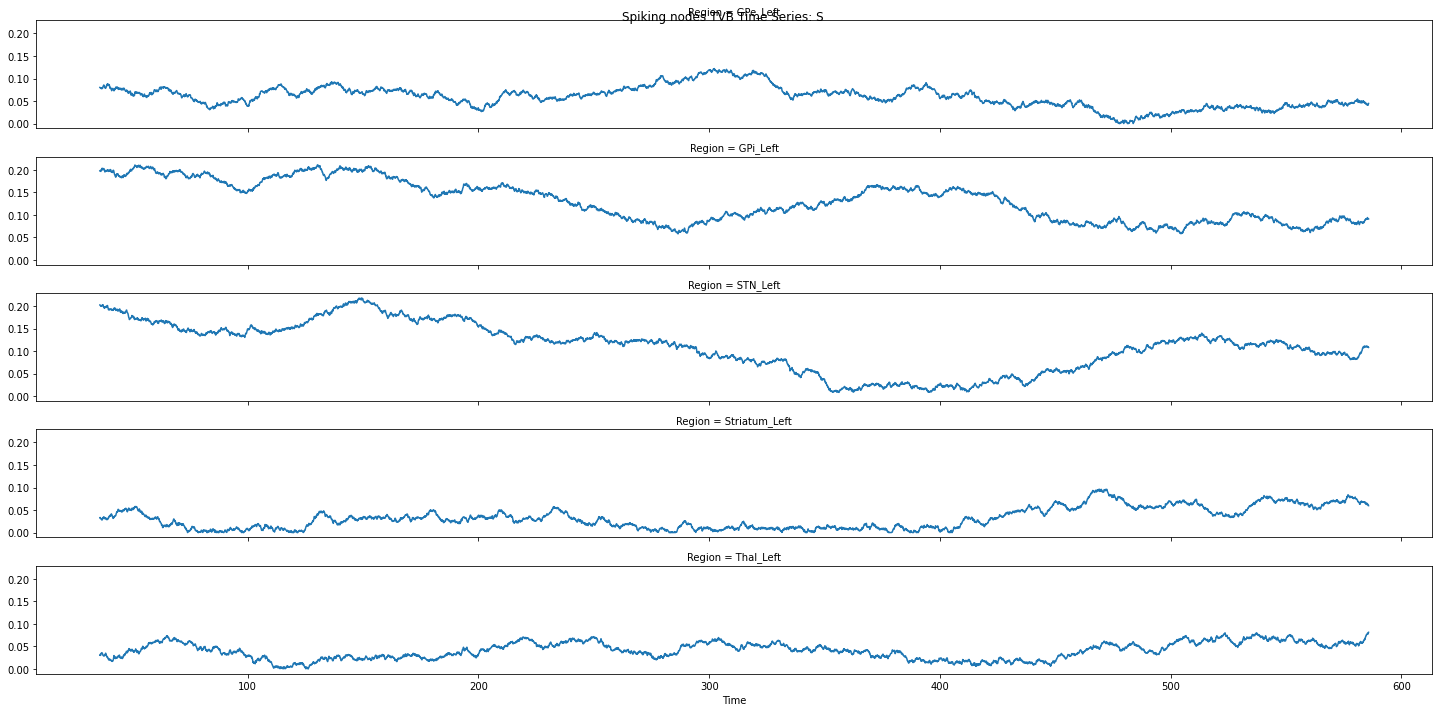

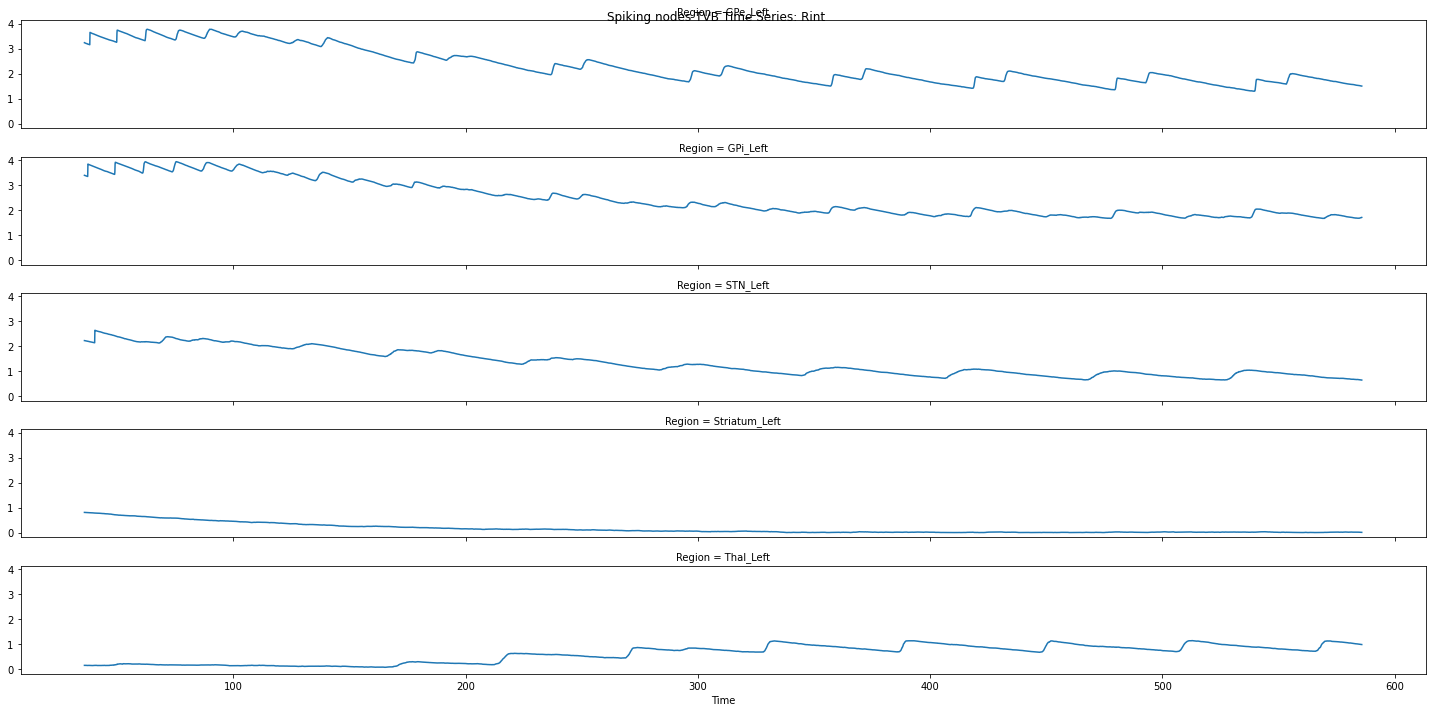

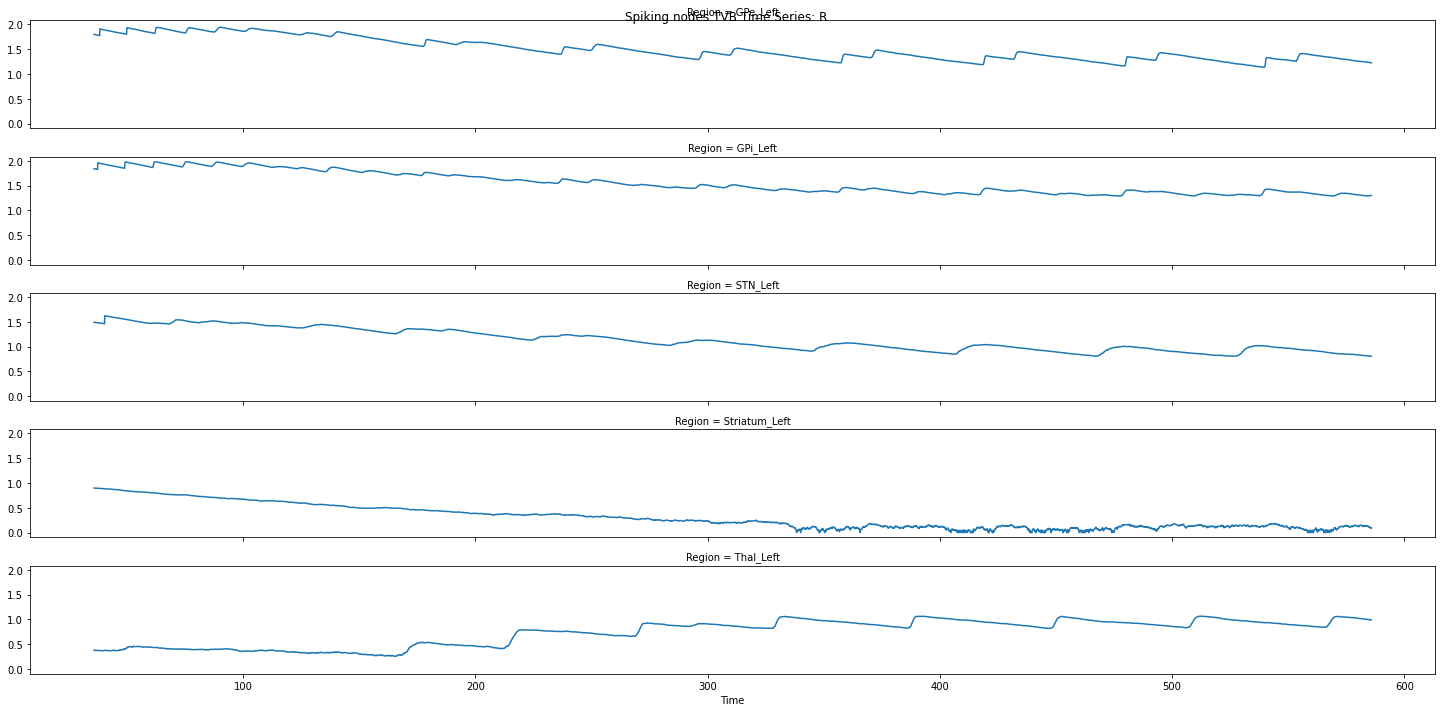

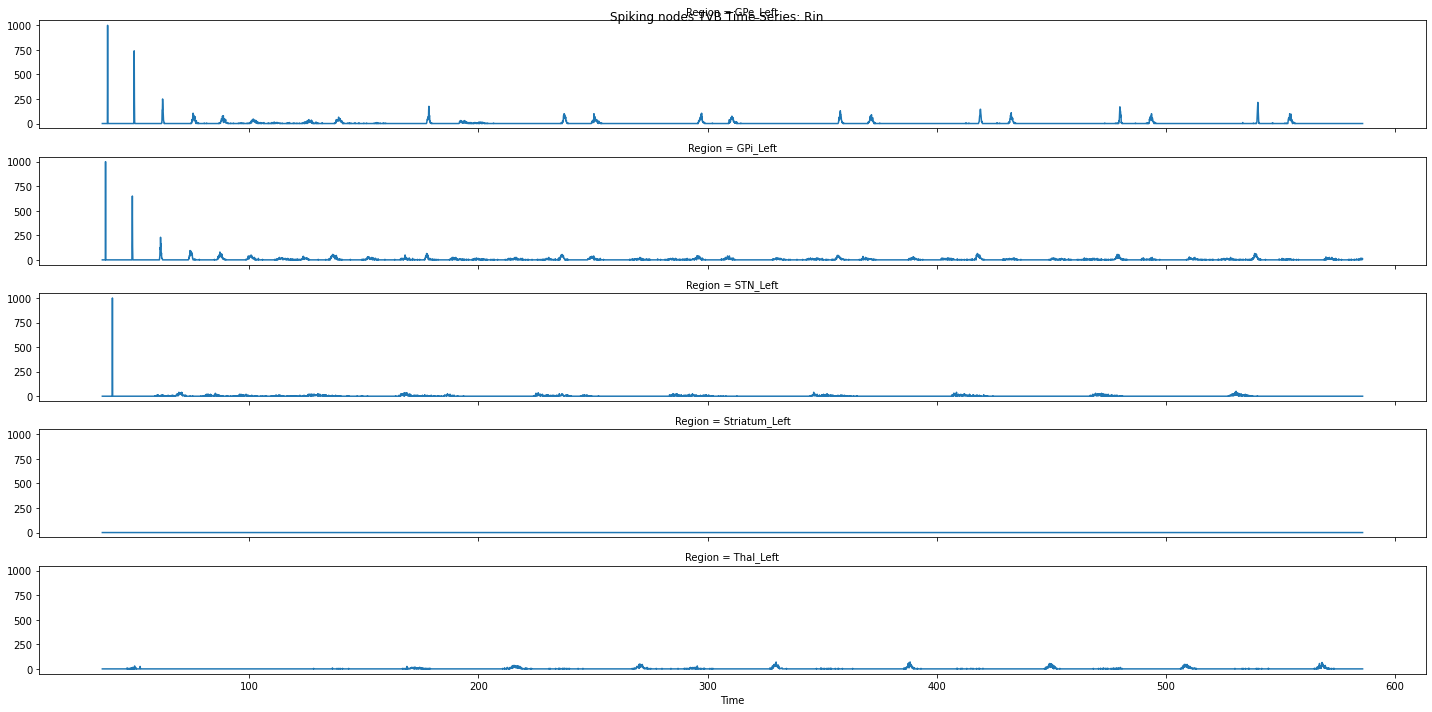

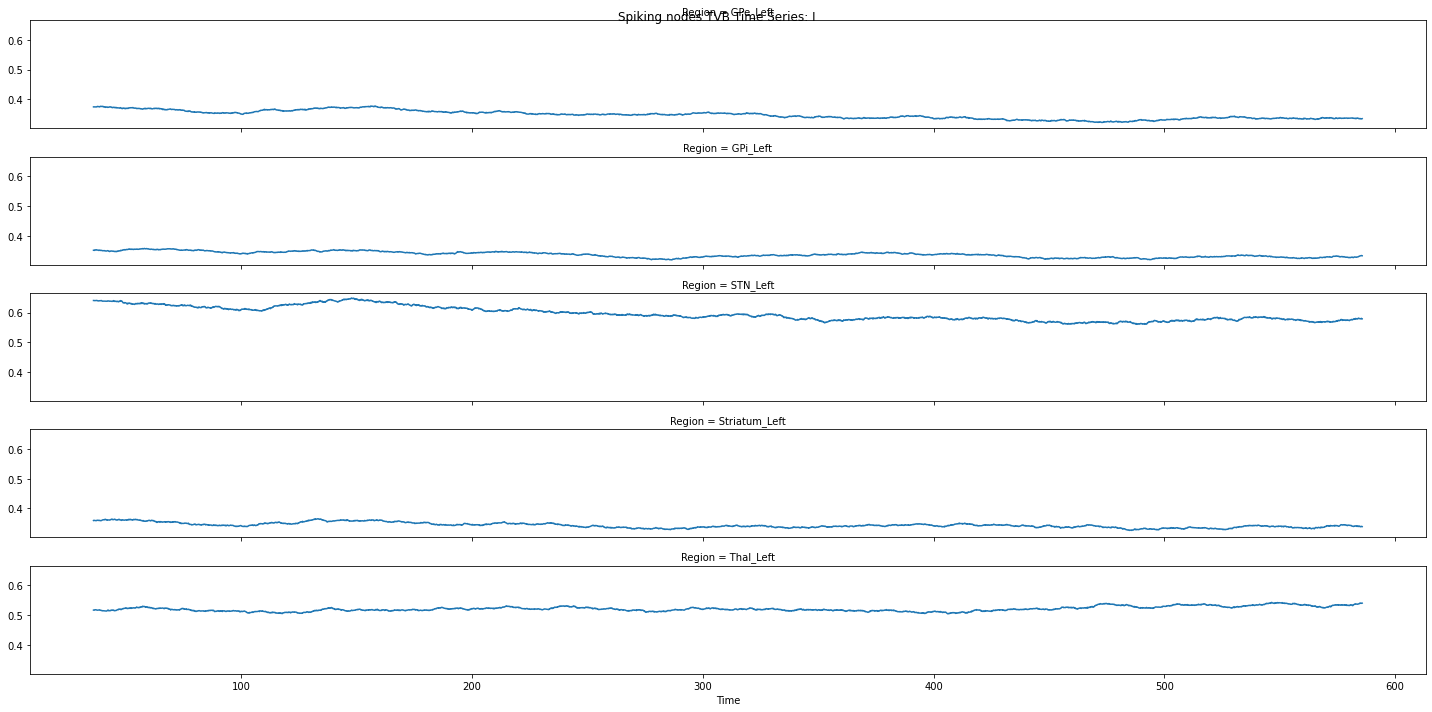

In [20]:
# Focus on the nodes modelled in NEST: 
n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
source_ts_nest.plot_timeseries(plotter_config=plotter.config, 
                               hue="Region" if source_ts_nest.shape[2] > MAX_REGIONS_IN_ROWS else None, 
                               per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS, 
                               figsize=FIGSIZE, figname="Spiking nodes TVB Time Series");

In [21]:
# # Focus on the nodes modelled in NEST: raster plot
# if source_ts_nest.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
#     source_ts_nest.plot_raster(plotter_config=plotter.config, 
#                                per_variable=source_ts_nest.shape[1] > MAX_VARS_IN_COLS,
#                                figsize=FIGSIZE, figname="Spiking nodes TVB Time Series Raster");

### Interactive time series plot

In [22]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
#                                                                              connectivity=source_ts.connectivity))

### Spiking Network plots

In [23]:
from tvb_multiscale.tvb_elephant.spiking_network_analyser import SpikingNetworkAnalyser
# Create a SpikingNetworkAnalyzer:
spikeNet_analyzer = \
    SpikingNetworkAnalyser(spikeNet=nest_network,
                           start_time=t[0], end_time=t[-1], 
                           period=simulator.monitors[0].period, transient=transient,
                           time_series_output_type="TVB", return_data=True, 
                           force_homogeneous_results=True, connectivity=simulator.connectivity)

### Plot spikes' raster and mean spike rates and correlations

In [24]:
# Spikes rates and correlations per Population and Region
spikes_res = \
    spikeNet_analyzer.\
        compute_spikeNet_spikes_rates_and_correlations(
            populations_devices=None, regions=None,
            rates_methods=[], rates_kwargs=[{}],rate_results_names=[],
            corrs_methods=[], corrs_kwargs=[{}], corrs_results_names=[], bin_kwargs={},
            data_method=spikeNet_analyzer.get_spikes_from_device, data_kwargs={},
            return_devices=False
        );

/home/docker/env/neurosci/lib/python3.7/site-packages/elephant/conversion.py:1169: UserWarning:Binning discarded 15 last spike(s) of the input spiketrain
/home/docker/env/neurosci/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning:invalid value encountered in true_divide
/home/docker/env/neurosci/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning:invalid value encountered in true_divide


<xarray.DataArray "Mean Populations' Spikes' Rates" (Population: 4, Region: 5)>
array([[        nan,         nan, 18.59371867,         nan, 16.6533306 ],
       [34.97699526, 38.53770739,         nan,         nan,         nan],
       [        nan,         nan,         nan,  0.        ,         nan],
       [        nan,         nan,         nan,  0.        ,         nan]])
Coordinates:
  * Region      (Region) object 'GPe_Left' 'GPi_Left' ... 'Thal_Left'
  * Population  (Population) object 'E_spikes' 'I_spikes' ... 'IiSN_spikes'
<xarray.DataArray "Populations' Correlation Coefficient" (Population_i: 4, Population_j: 4, Region_i: 5, Region_j: 5)>
array([[[[            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,             nan,
                      nan,             nan],
         [            nan,             nan,  1.00000000e+00,
                      nan, -2.27342980e-02],
         [            nan, 

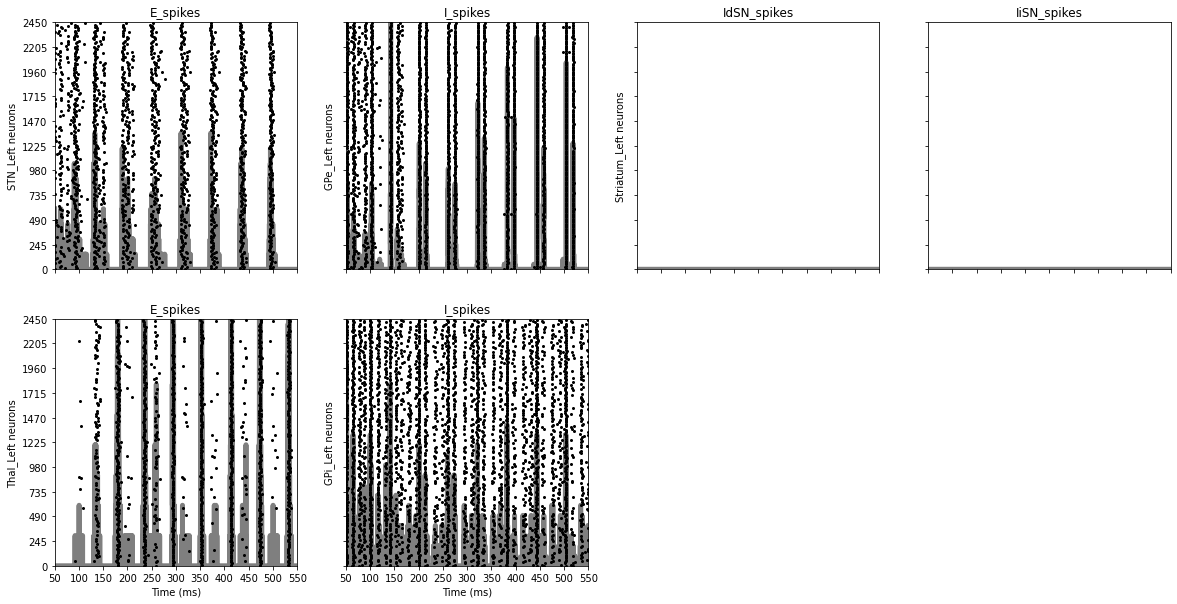

<Figure size 432x288 with 0 Axes>

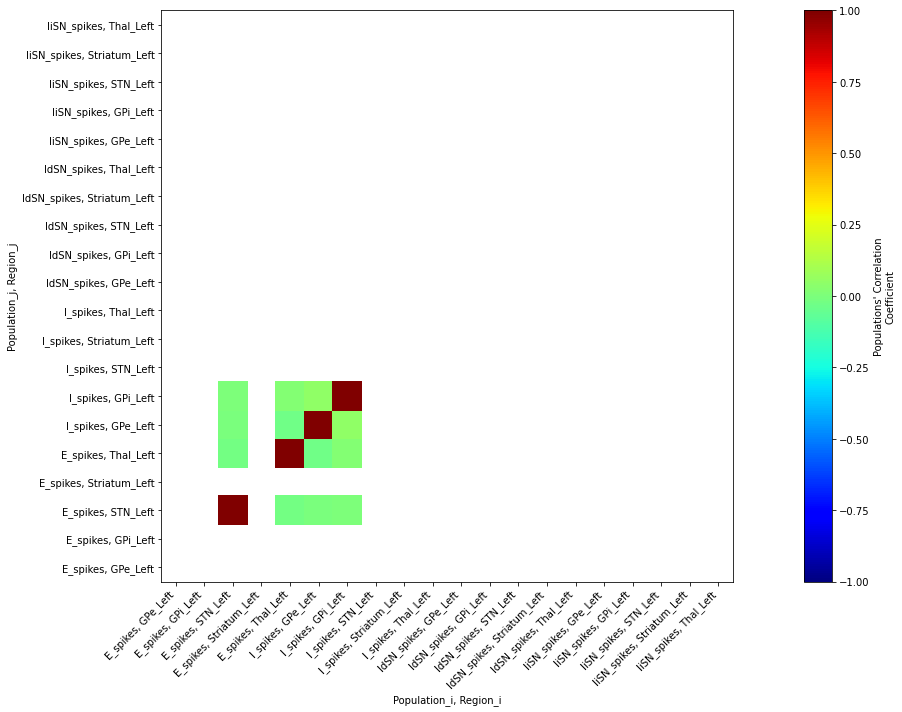

In [25]:
if spikes_res:
    print(spikes_res["mean_rate"])
    print(spikes_res["spikes_correlation_coefficient"])
    # Plot spikes' rasters together with mean population's spikes' rates' time series
    if plotter:
        plotter.plot_spike_events(spikes_res["spikes"], rates=spikes_res["mean_rate_time_series"], 
                                  figsize=FIGSIZE) # 
        from tvb_multiscale.core.plot.correlations_plot import plot_correlations
        plot_correlations(spikes_res["spikes_correlation_coefficient"], plotter)

In [26]:
print("Mean spike rates:")
for pop in spikes_res["mean_rate"].coords["Population"]:
    for reg in spikes_res["mean_rate"].coords["Region"]:
        if not np.isnan(spikes_res["mean_rate"].loc[pop, reg]):
            print("%s - %s: %g" % (pop.values.item().split("_spikes")[0], reg.values.item(), 
                                   spikes_res["mean_rate"].loc[pop, reg].values.item()))

Mean spike rates:
E - STN_Left: 18.5937
E - Thal_Left: 16.6533
I - GPe_Left: 34.977
I - GPi_Left: 38.5377
IdSN - Striatum_Left: 0
IiSN - Striatum_Left: 0


In [27]:
if spikes_res and writer:
    writer.write_object(spikes_res["spikes"].to_dict(), 
                        path=os.path.join(config.out.FOLDER_RES,  "Spikes") + ".h5");
    writer.write_object(spikes_res["mean_rate"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["mean_rate"].name) + ".h5");
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                              spikes_res["mean_rate_time_series"]._data,
                               connectivity=spikes_res["mean_rate_time_series"].connectivity),
                           os.path.join(config.out.FOLDER_RES,
                                        spikes_res["mean_rate_time_series"].title) + ".h5",
                           recursive=False);
    writer.write_object(spikes_res["spikes_correlation_coefficient"].to_dict(),
                        path=os.path.join(config.out.FOLDER_RES,
                                          spikes_res["spikes_correlation_coefficient"].name) + ".h5");

2021-03-10 14:40:45,831 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/basal_ganglia/outputs/Izhikevich/TVBcortex_opt/stim/res/Spikes.h5
2021-03-10 14:40:45,831 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/tvb_nest/notebooks/basal_ganglia/outputs/Izhikevich/TVBcortex_opt/stim/res/Spikes.h5
2021-03-10 14:40:45,856 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[401 402 403 ... 561 510 407] !

2021-03-10 14:40:45,856 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Left" (2 members)> dataset <class 'numpy.ndarray'> senders:
[401 402 403 ... 561 510 407] !

2021-03-10 14:40:45,864 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/E_spikes/STN_Left" (2

2021-03-10 14:40:46,014 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> dims:
['Population' 'Region'] !

2021-03-10 14:40:46,021 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[        nan         nan 18.59371867         nan 16.6533306 ]
 [34.97699526 38.53770739         nan         nan         nan]
 [        nan         nan         nan  0.                 nan]
 [        nan         nan         nan  0.                 nan]] !

2021-03-10 14:40:46,021 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Mean Populations' Spikes' Rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[        nan         nan 18.59371867         nan 16.6533306 ]
 [34.97699526 38.53770739         nan         nan         nan]
 [        nan         nan  

2021-03-10 14:40:46,399 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "Populations' Correlation Coefficient.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[[[            nan             nan             nan             nan
                nan]
   [            nan             nan             nan             nan
                nan]
   [            nan             nan  1.00000000e+00             nan
    -2.27342980e-02]
   [            nan             nan             nan             nan
                nan]
   [            nan             nan -2.27342980e-02             nan
     1.00000000e+00]]

  [[            nan             nan             nan             nan
                nan]
   [            nan             nan             nan             nan
                nan]
   [-6.94990241e-03  1.10313817e-04             nan             nan
                nan]
   [            nan             nan             nan             nan
                nan]
   [

2021-03-10 14:40:46,425 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> data:
['E_spikes' 'I_spikes' 'IdSN_spikes' 'IiSN_spikes'] !

2021-03-10 14:40:46,425 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/coords/Population_i" (2 members)> dataset <class 'numpy.ndarray'> data:
['E_spikes' 'I_spikes' 'IdSN_spikes' 'IiSN_spikes'] !

2021-03-10 14:40:46,434 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-10 14:40:46,434 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-03-10 14:40:46,438 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-03-10 14:40:46,438 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file as a n

### Get  SpikingNetwork mean field variable time series and plot them

2021-03-10 14:40:52,221 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:53,261 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:54,329 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:55,399 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:56,690 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:58,108 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2021-03-10 14:40:59,261 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

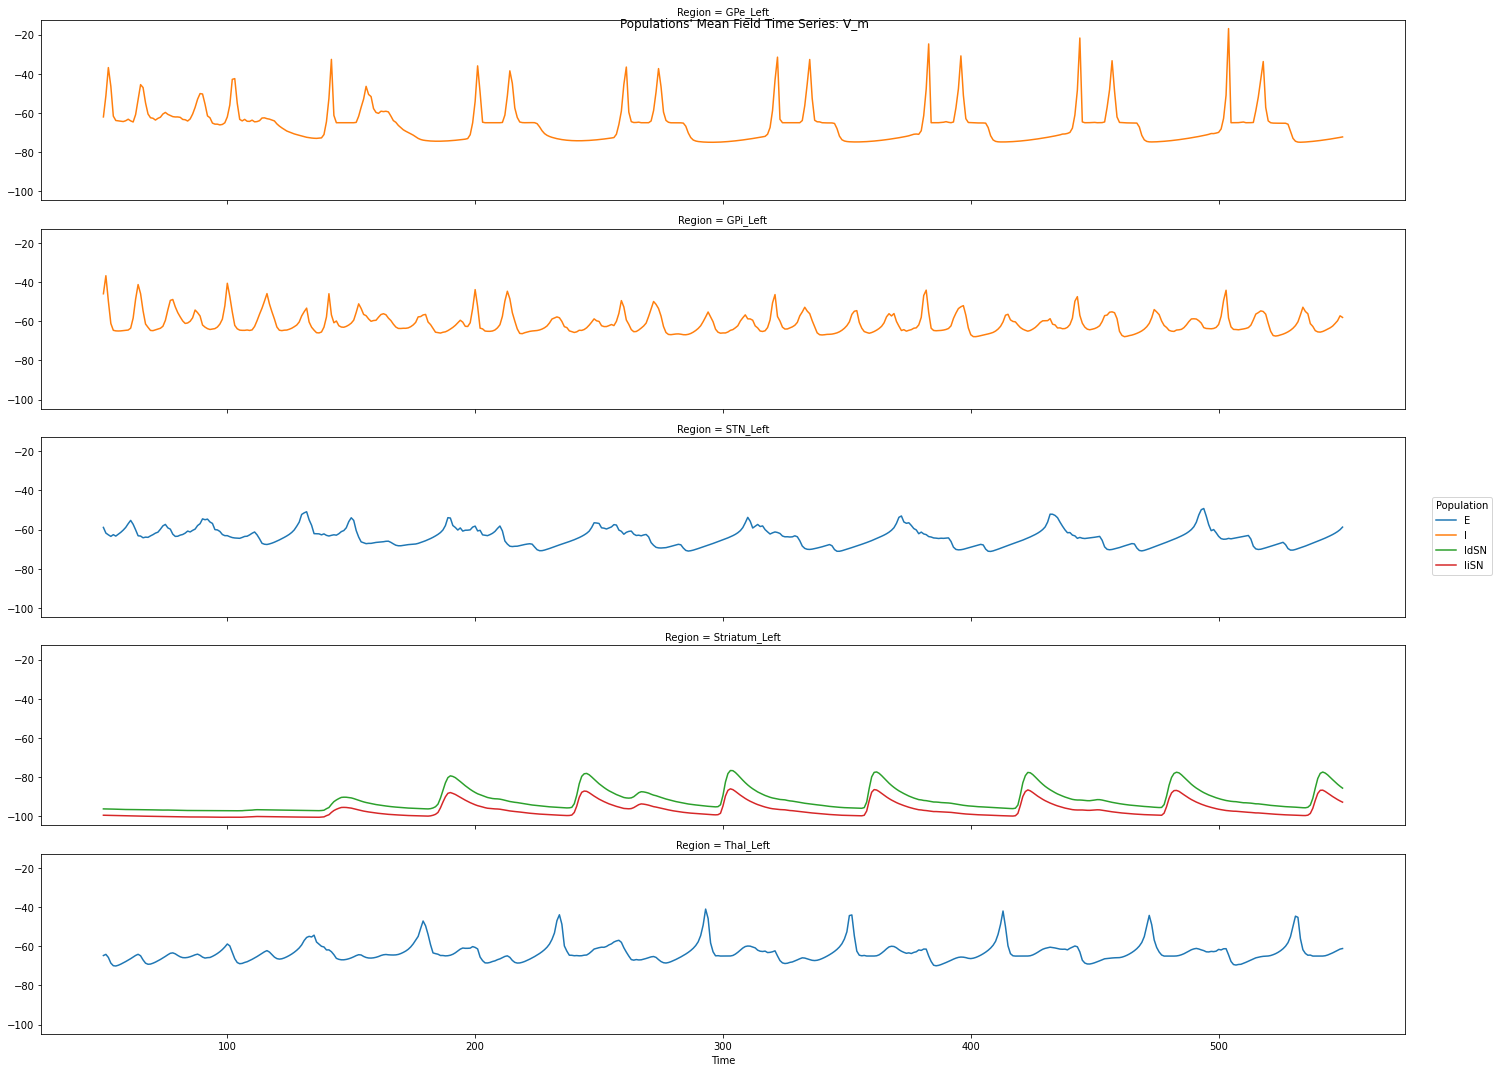

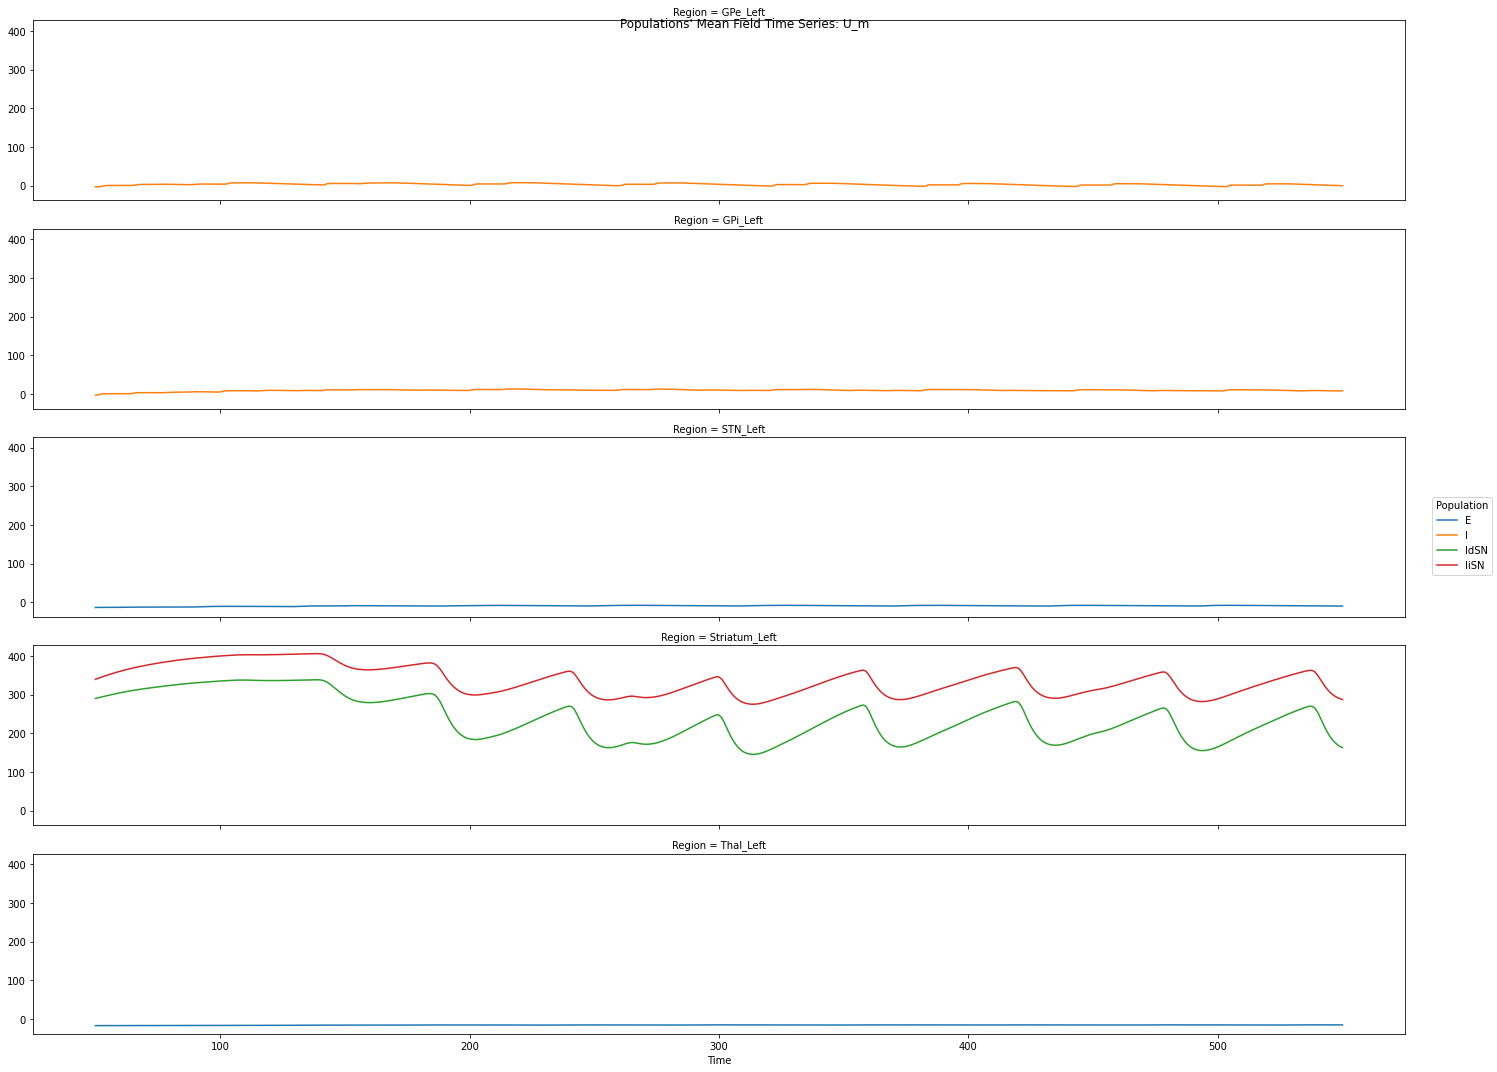

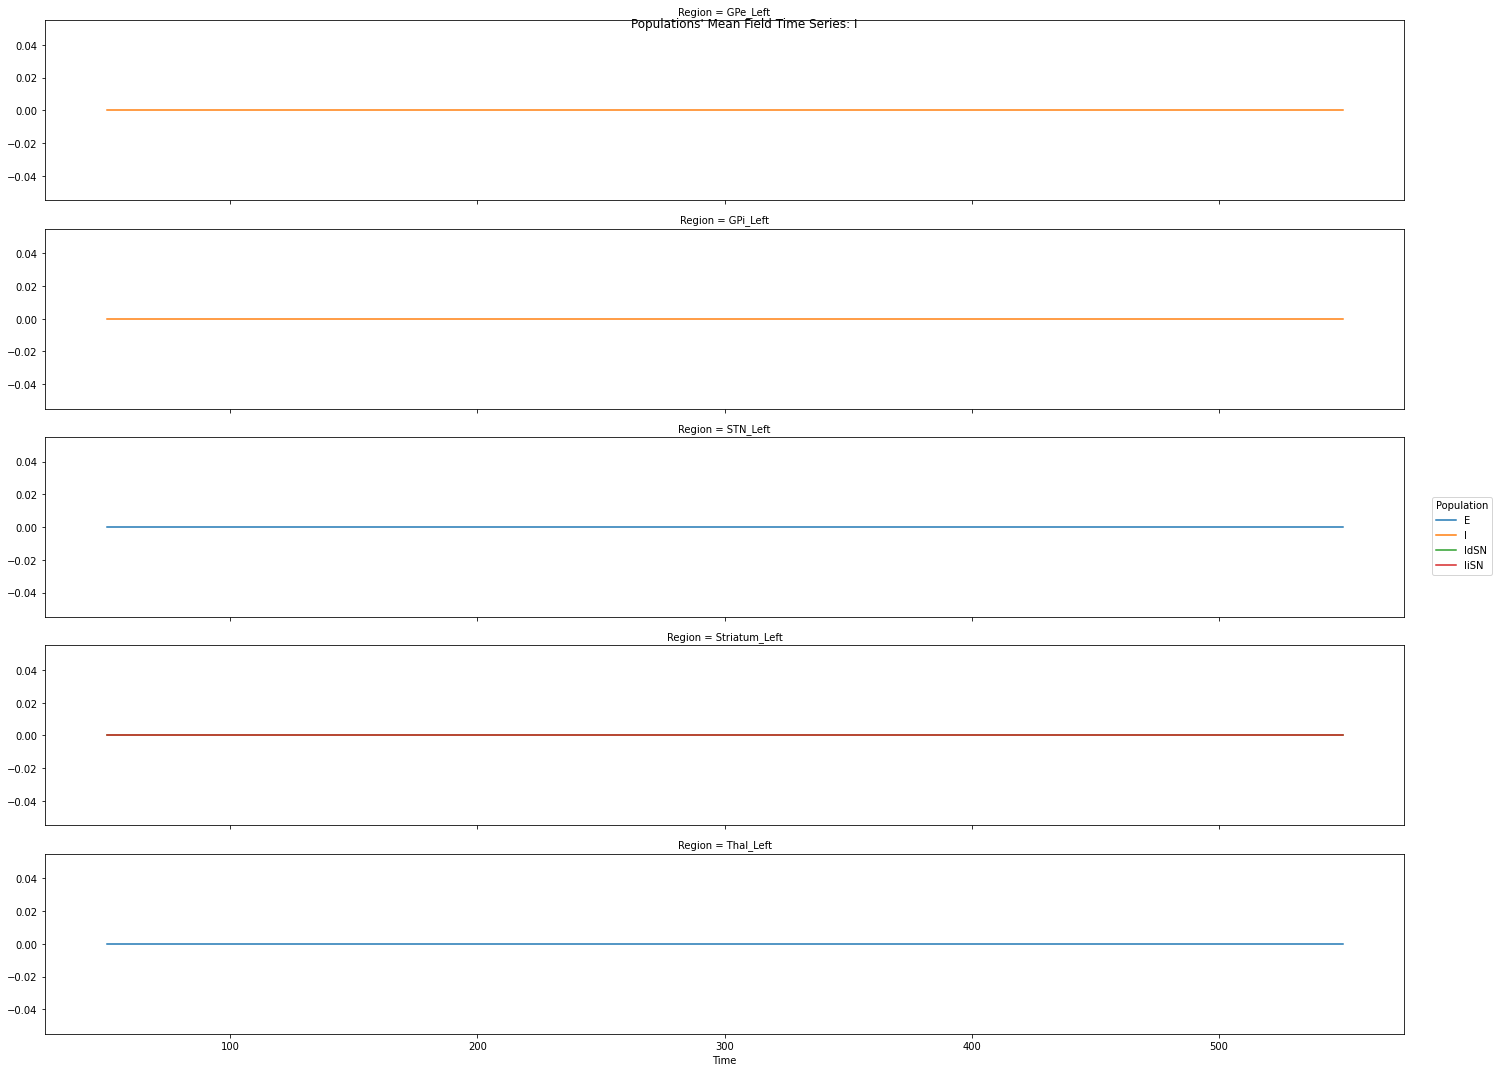

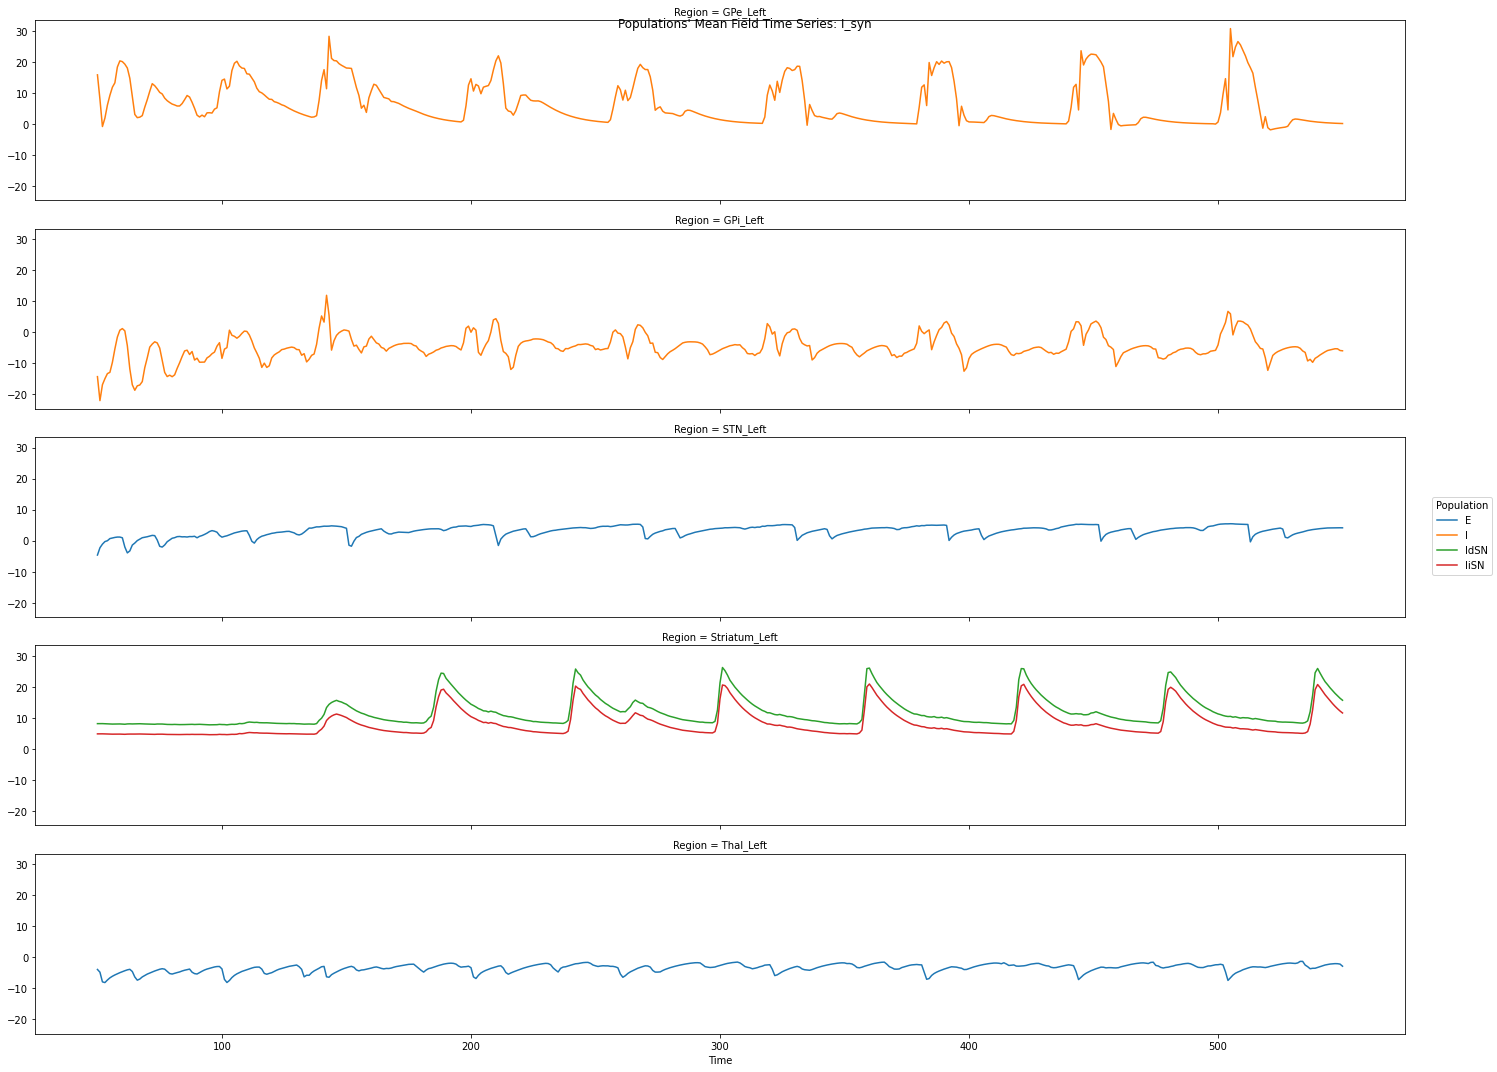

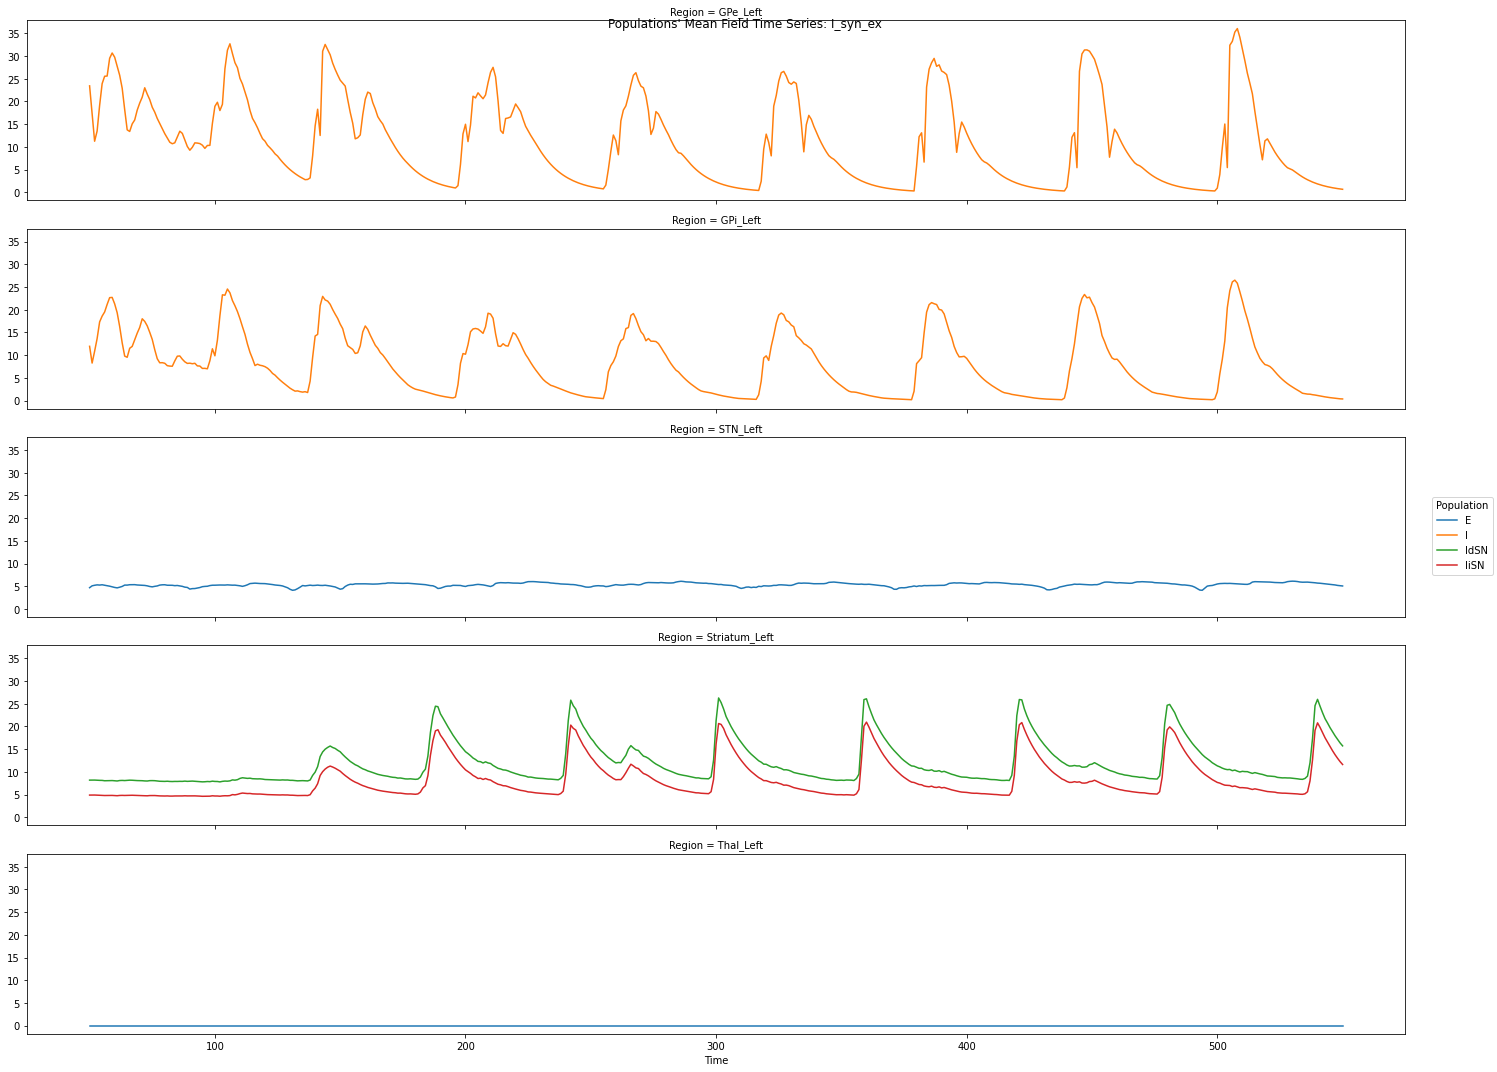

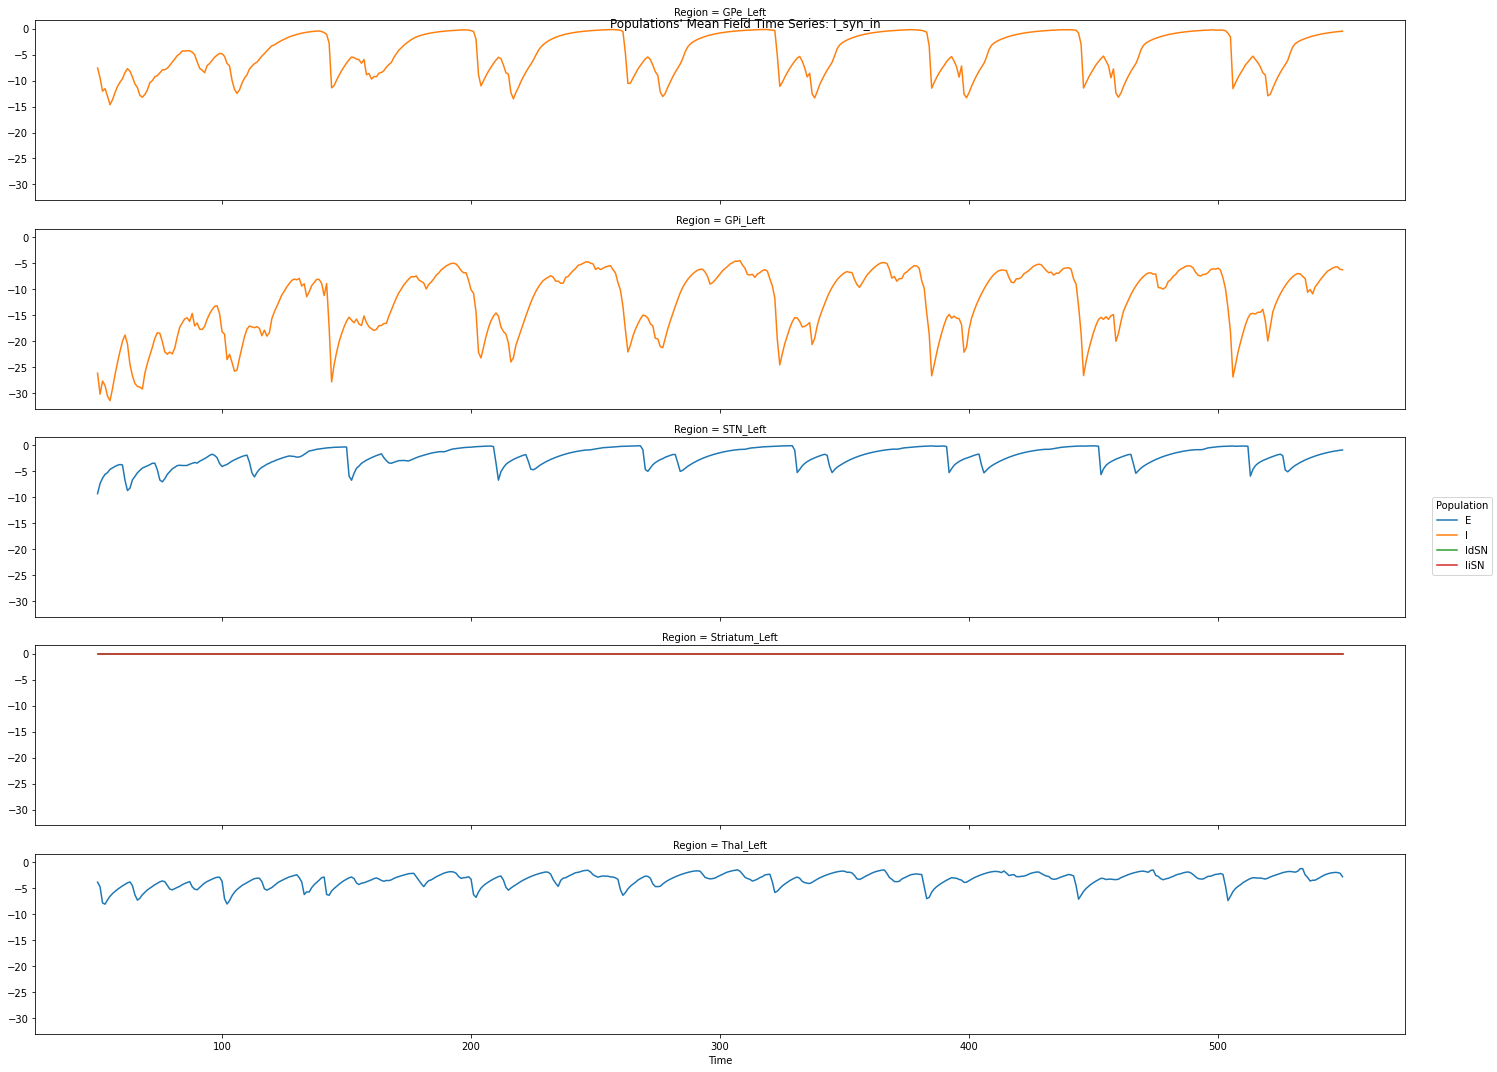

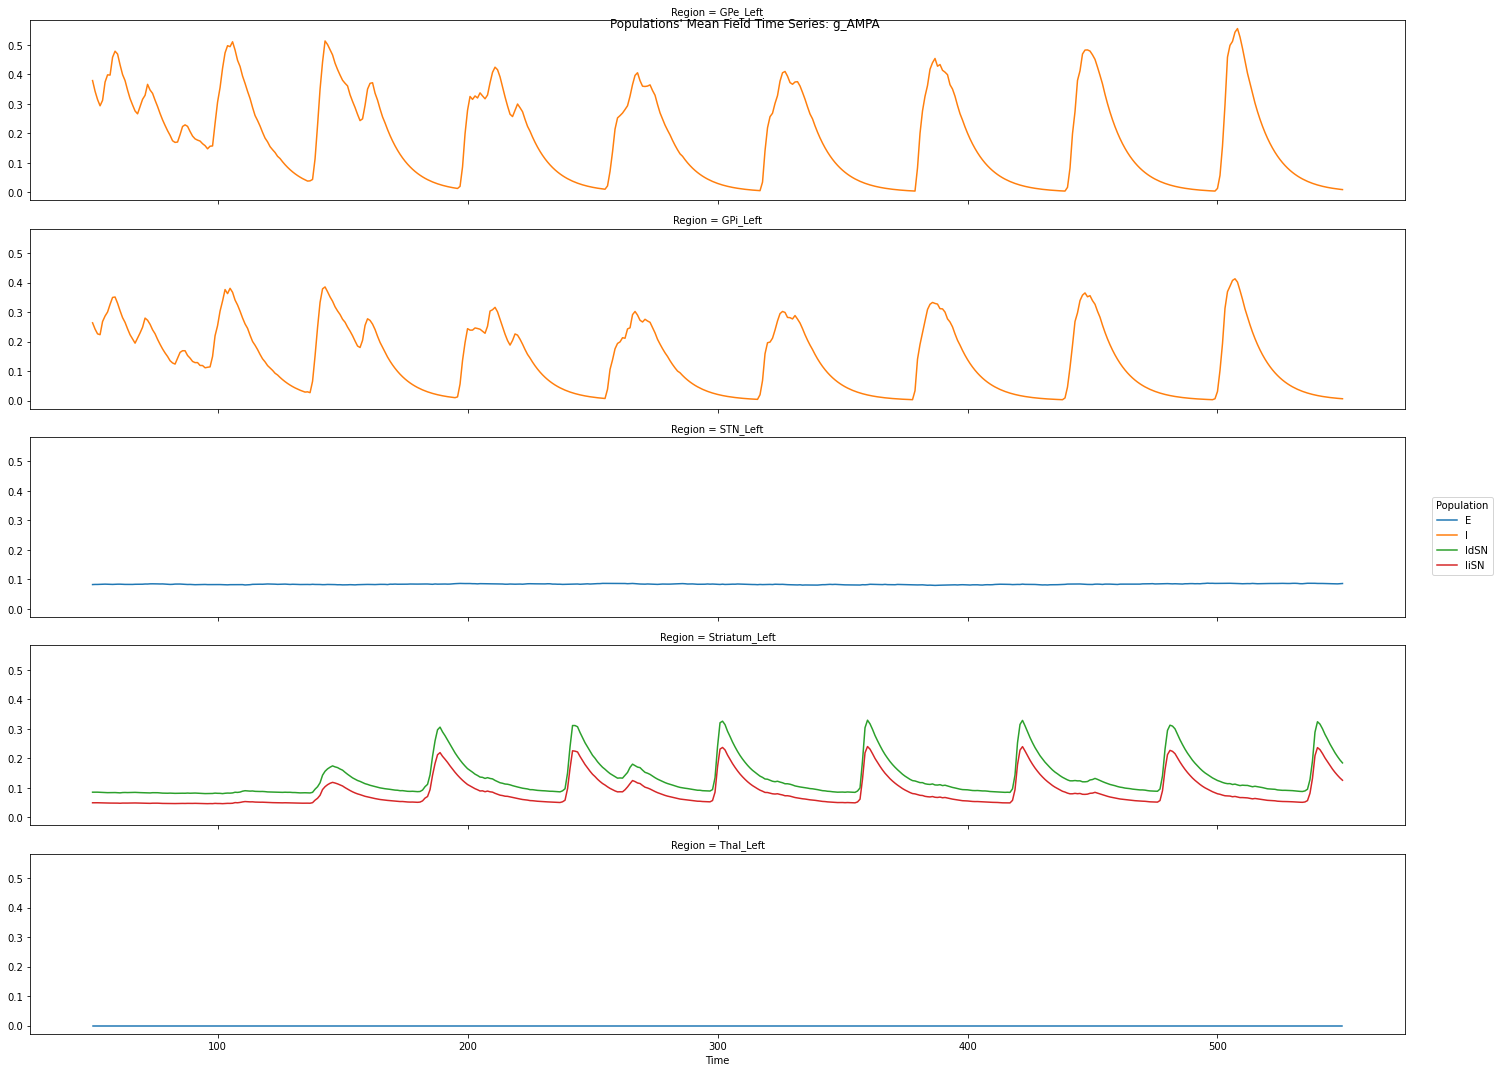

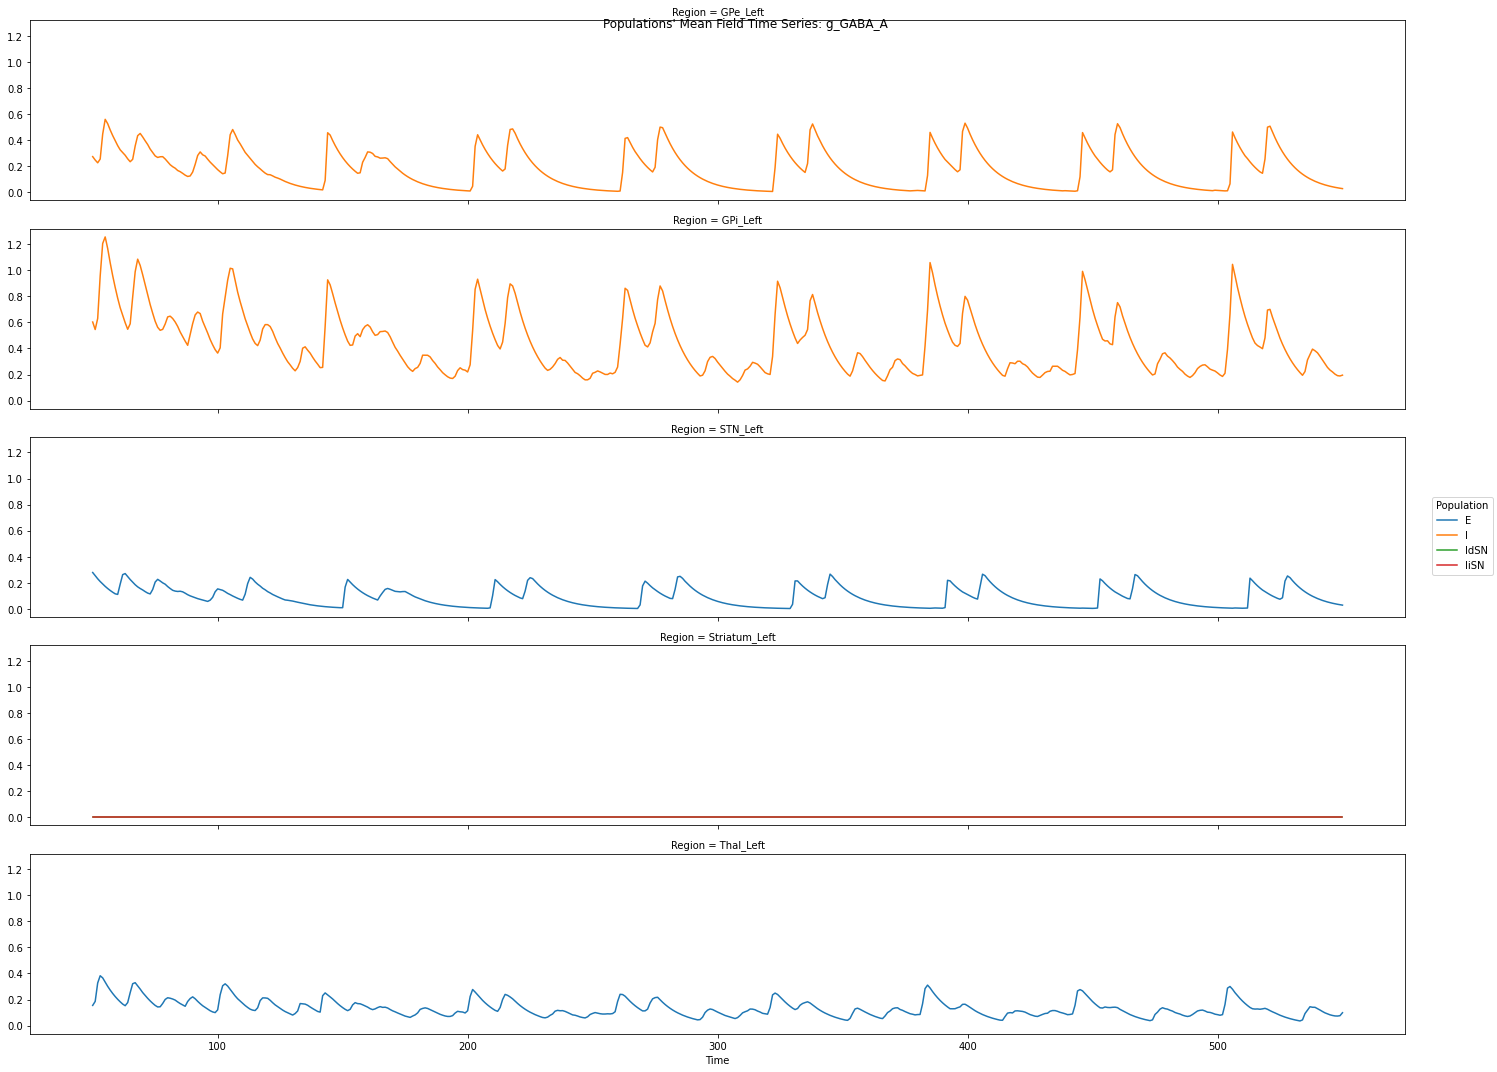

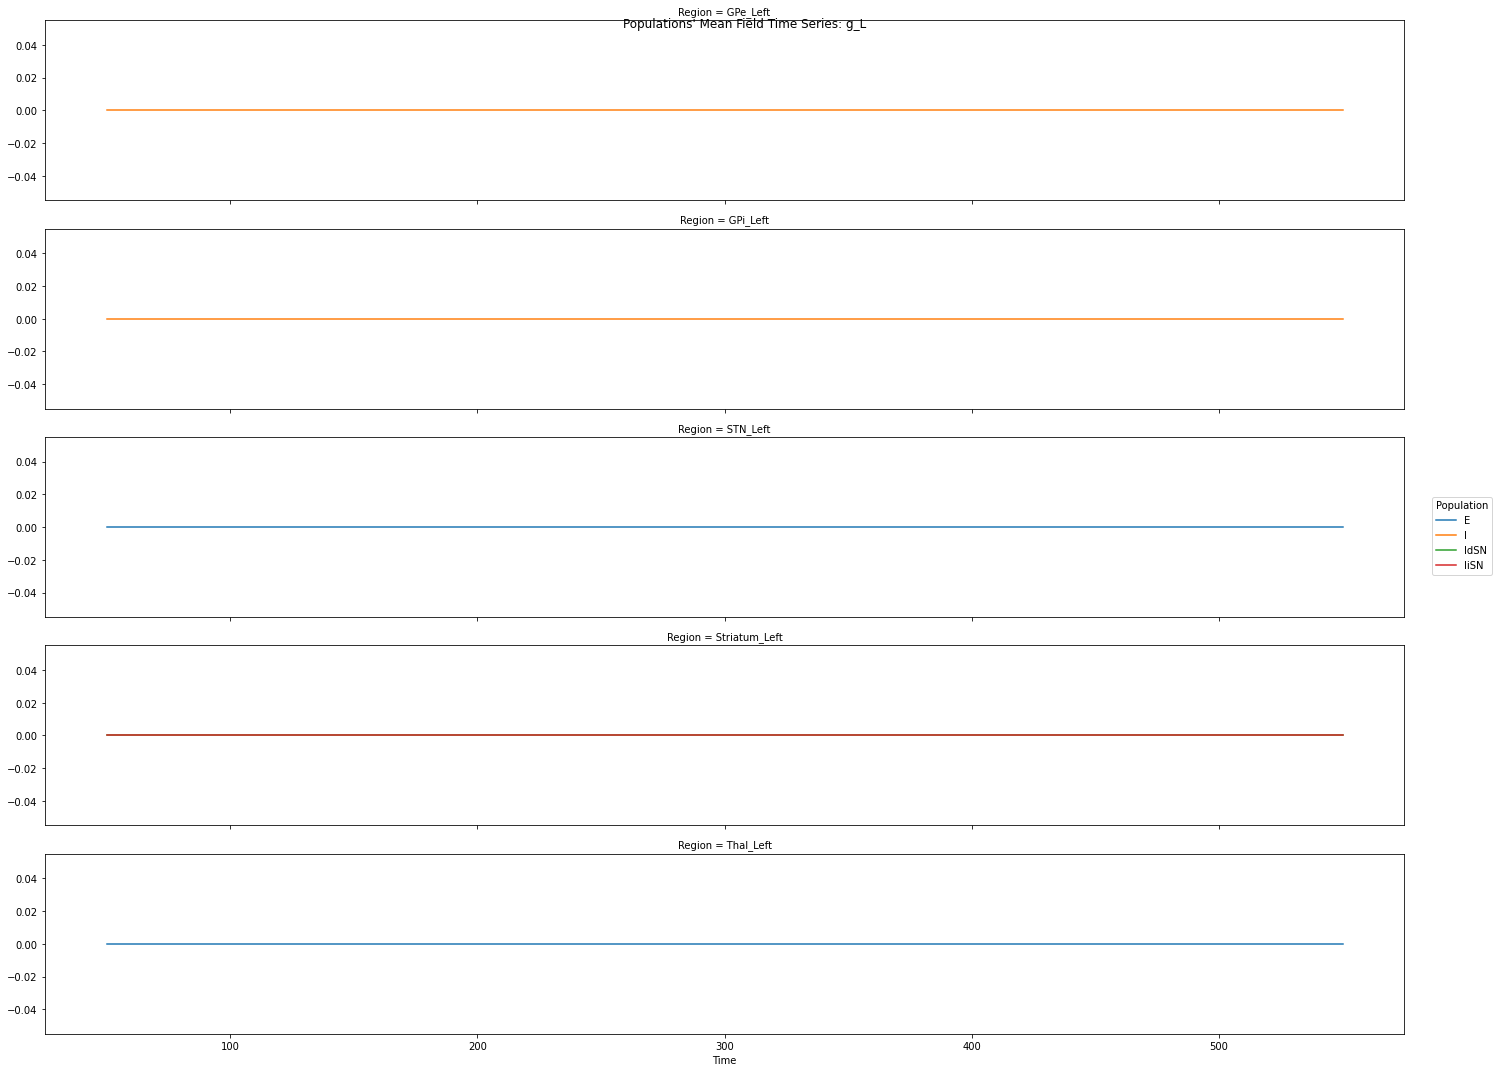

In [28]:
# Continuous time variables' data of spiking neurons
if plot_per_neuron:
    spikeNet_analyzer.return_data = True
else:
    spikeNet_analyzer.return_data = False
spikeNet_ts = \
    spikeNet_analyzer. \
         compute_spikeNet_mean_field_time_series(populations_devices=None, regions=None, variables=None,
                                                 computations_kwargs={}, data_kwargs={}, return_devices=False)
if spikeNet_ts:
    if plot_per_neuron:
        mean_field_ts = spikeNet_ts["mean_field_time_series"]  # mean field
        spikeNet_ts = spikeNet_ts["data_by_neuron"]  # per neuron data
    else:
        mean_field_ts = spikeNet_ts
    if mean_field_ts and mean_field_ts.size > 0:
        mean_field_ts.plot_timeseries(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS)
        if mean_field_ts.number_of_labels > MIN_REGIONS_FOR_RASTER_PLOT:
            mean_field_ts.plot_raster(plotter_config=plotter.config, 
                                      per_variable=mean_field_ts.shape[1] > MAX_VARS_IN_COLS,
                                      linestyle="--", alpha=0.5, linewidth=0.5)
else:
    mean_field_ts = None

In [29]:
# Write results to file:
if mean_field_ts and writer:
    writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(
                                       mean_field_ts._data,
                                       connectivity=mean_field_ts.connectivity),
                           os.path.join(config.out.FOLDER_RES, mean_field_ts.title) + ".h5", 
                           recursive=False)

### Compute per neuron spikes' rates times series and plot them

In [30]:
if spikes_res and plot_per_neuron:
    from tvb.simulator.plot.base_plotter import pyplot
    spikeNet_analyzer.return_data = False
    rates_ts_per_neuron = \
        spikeNet_analyzer. \
            compute_spikeNet_rates_time_series(populations_devices=None, regions=None,
                                               computations_kwargs={}, data_kwargs={},
                                               return_spikes_trains=False, return_devices=False);
    if rates_ts_per_neuron is not None and rates_ts_per_neuron.size:
        # Regions in rows
        row = rates_ts_per_neuron.dims[2] if rates_ts_per_neuron.shape[2] > 1 else None
        if row is None:
            # Populations in rows
            row = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
            col = None
        else:
            # Populations in columns
            col = rates_ts_per_neuron.dims[1] if rates_ts_per_neuron.shape[1] > 1 else None
        pyplot.figure()
        rates_ts_per_neuron.plot(y=rates_ts_per_neuron.dims[3], row=row, col=col, cmap="jet")
        plotter.base._save_figure(figure_name="Spike rates per neuron")
        # del rates_ts_per_neuron # to free memory

### Plot per neuron SpikingNetwork time series

In [31]:
# Regions in rows
if plot_per_neuron and spikeNet_ts.size:
    row = spikeNet_ts.dims[2] if spikeNet_ts.shape[2] > 1 else None
    if row is None:
        # Populations in rows
        row = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
        col = None
    else:
        # Populations in cols
         col = spikeNet_ts.dims[3] if spikeNet_ts.shape[3] > 1 else None
    for var in spikeNet_ts.coords[spikeNet_ts.dims[1]]:
        this_var_ts = spikeNet_ts.loc[:, var, :, :, :]
        this_var_ts.name = var.item()
        pyplot.figure()
        this_var_ts.plot(y=spikeNet_ts.dims[4], row=row, col=col, cmap="jet", figsize=FIGSIZE)
        plotter.base._save_figure(
            figure_name="Spiking Network variables' time series per neuron: %s" % this_var_ts.name)
    del spikeNet_ts # to free memory

# References

1 Sanz Leon P, Knock SA, Woodman MM, Domide L, <br>
  Mersmann J, McIntosh AR, Jirsa VK (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics 7:10. doi: 10.3389/fninf.2013.00010 <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK (2013).  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

4 Baladron, J., Nambu, A., & Hamker, F. H. (2019). <br>
  The subthalamic nucleus‐external globus pallidus loop biases <br>
  exploratory decisions towards known alternatives: A neuro‐computational study. <br>
  European Journal of Neuroscience, 49:754–767. https://doi.org/10.1111/ejn.13666 <br>
  
5 Maith O, Villagrasa Escudero F, Ülo Dinkelbach H, Baladron J, <br>
  Horn, A, Irmen F, Kühn AA, Hamker FH (2020).<br>
  A computational model‐based analysis of basal ganglia pathway changes <br>
  in Parkinson’s disease inferred from resting‐state fMRI <br>
  European Journal of Neuroscience, 00:1–18. https://doi.org/10.1111/ejn.14868
  

In [32]:
for interface in tvb_nest_model.tvb_to_spikeNet_interfaces:
    rates = []
    print("\n%s" % interface.label)
    for iR, region in enumerate(interface.keys()):
        events = tvb_nest_model.tvb_to_spikeNet_interfaces[0][region]._record.get("events")
        times = np.array(events["times"])[np.where(events["times"] > transient)]
        if len(times):
            rate = len(times) / np.unique(events["senders"]).size / (simulation_length - transient) * 1000.0
        else:
            rate = 0.0
        rates.append(rate)
        print("%s rate = %g = %g (expected)" % (region, rate, TVBrate[iR]))
    total_rate = np.sum(rates)
    print("mean rate = %g (%g) = %g (expected)" % (np.mean(rates), total_rate /52, TVBrate.mean()))


R
Precentral_L rate = 51.83 = 51.4846 (expected)
Frontal_Sup_2_L rate = 64.7533 = 65.1411 (expected)
Frontal_Mid_2_L rate = 108.217 = 107.802 (expected)
Frontal_Inf_Oper_L rate = 2.4843 = 0.871471 (expected)
Frontal_Inf_Tri_L rate = 65.27 = 65.8214 (expected)
Frontal_Inf_Orb_2_L rate = 97.2333 = 97.7219 (expected)
Rolandic_Oper_L rate = 2.36885 = 0.902287 (expected)
Supp_Motor_Area_L rate = 28.1533 = 28.4147 (expected)
Olfactory_L rate = 2.15311 = 0.722656 (expected)
Frontal_Sup_Medial_L rate = 38.06 = 38.0712 (expected)
Frontal_Med_Orb_L rate = 2.21505 = 0.629952 (expected)
Rectus_L rate = 79.2433 = 79.3399 (expected)
OFCmed_L rate = 72.3667 = 72.6462 (expected)
OFCant_L rate = 67.9267 = 67.1218 (expected)
OFCpost_L rate = 38.6067 = 38.5219 (expected)
OFClat_L rate = 2.72149 = 1.73464 (expected)
Insula_L rate = 88.2533 = 88.1484 (expected)
Cingulate_Ant_L rate = 2.30088 = 0.885318 (expected)
Cingulate_Mid_L rate = 2.42667 = 1.2398 (expected)
Cingulate_Post_L rate = 2.21965 = 0.59007 